# 02_MARES_mooring_DATA-Analysis

### Import packages

In [2]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np, numpy.ma as ma
import xarray as xr
import pandas as pd

# time
from datetime import datetime, timedelta
import calendar
from calendar import monthrange

# local system 
import sys  
import glob
import os

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors
import cmocean
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import Normalize
from matplotlib.ticker import MultipleLocator

import matplotlib.dates as mdates

# geo plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy import img_transform

from metpy.units import units


import shapely
from shapely.geometry import Point
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

# sys.path.append('../Libraries_functions/')
# from LIB_ASI_SIC_UniB import grab_ASI_SIC

# from LIB_geo_plot import *
# # from LIB_access_ERA5 import shift_bylons
# from LIB_PPdrift_NSIDC0116 import grab_icedrift_range

# path to own functions
sys.path.append('../../')
import plot_simply.general as plotter
import plot_simply.geomap as geomap
import geofunc.shapes as geoshape
import geofunc.vectors as vectors
import data_unibremen.SIC as unisic
import data_osisaf.icedrift_lr as osidrift
import data_nsidc.icedrift as icedrift
import timeseries.adjust as tseries
import geofunc.vectors as vectors

import timeseries.analyze as tanalyze

sys.path.append('../')
import functions as fn



from scipy import stats


plt.style.use('../jgr_oceans.mplstyle')

def SAVE(fig, filename):
    fig.savefig(filename, bbox_inches='tight', pad_inches=0.05)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:

# open region polygon
df = pd.read_csv('../data/coastal_region_bounds_v7.csv')
reg_poly = geoshape.make_polygon(np.stack((df['lons'], df['lats']), axis=1))


## Import data

In [4]:
# Save to file
df = pd.read_csv('../data/constants.csv')
df = df.set_index('var')
df

cst = {}
for variable in list(df.index):
    cst[variable] = df.loc[variable]['value'] * units(df.loc[variable]['units'])
    
cst

{'Cp_o': <Quantity(3850.0, 'joule / kilogram / delta_degree_Celsius')>,
 'Cp_a': <Quantity(1004.0, 'joule / kilogram / delta_degree_Celsius')>,
 'sigma_sb': <Quantity(5.670367e-08, 'watt / meter ** 2 / kelvin ** 4')>,
 'rho_a': <Quantity(1.225, 'kilogram / meter ** 3')>,
 'rho_o': <Quantity(1028.0, 'kilogram / meter ** 3')>,
 'rho_i': <Quantity(917.0, 'kilogram / meter ** 3')>,
 'L_i': <Quantity(334000.0, 'joule / kilogram')>,
 'k_i': <Quantity(2.2, 'watt / meter / delta_degree_Celsius')>,
 'kappa': <Quantity(0.4, 'dimensionless')>,
 'St': <Quantity(0.0057, 'dimensionless')>,
 'omega': <Quantity(7.2921e-05, 'radian / second')>}

In [5]:
df = pd.read_csv('../data/compiled_stats.csv')
last_days = df.time[(df.final_day)&(df.single_day==False)].values

for cat in ['a10', 'ai', 'centermass_direction', 'max_length_direction']:
    df[f'{cat}_r'] = 90-df[f'{cat}']
    df[f'{cat}_r'][df[f'{cat}_r']<0]+=360

df['up'] = df['centermass_length'].values * np.cos(df['centermass_direction'].values*np.pi/180)
df['vp'] = df['centermass_length'].values * np.sin(df['centermass_direction'].values*np.pi/180)
    

df['si_km'] = df['si'] * units('cm/s').to('km/day') 

df['alongi_km'] = vectors.comp_along_theta(df['ui'], df['vi'], 165*units('degree')) * units('cm/s').to('km/day') 

/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_17130/3657443679.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{cat}_r'][df[f'{cat}_r']<0]+=360
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_17130/3657443679.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{cat}_r'][df[f'{cat}_r']<0]+=360
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_17130/3657443679.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

### Compile open dates 2016-2019

In [6]:
# #===============================================================

# # 2016-2017
# # time_range = slice(datetime(2016, 12, 1), datetime(2017, 4, 30,23))

# # 2017-2018
# # time_range = slice(datetime(2017, 12, 1), datetime(2018, 4, 30,23))

# # 2018-2019
# time_range = slice(datetime(2018, 12, 1), datetime(2019, 2, 10,23))

# #===============================================================

# #=============
# mooring = 'M1'
# #=============

# open_years = f'{time_range.start.year}_{time_range.stop.year}'

# # calculate projected ESE current component
# # u_val = np.cos(157.5 * np.pi/180)
# # v_val = np.sin(157.5 * np.pi/180)

# DS = xr.open_dataset(f'../data/polynya_size/daily_polynya_{time_range.stop.year}_sic10_v7.nc')
# DS = DS.sel(time = time_range)
# DS['length'] = (DS['l_max'])
# # DS['length'] = DS['l_max'] - DS['l_min']


# # ocean velocity
# #-----------------
# ds = xr.open_dataset(f"/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/{mooring}/{mooring}_hourly_ocean_currents_{open_years}.nc")
# ds.close()
# ds = ds.sel(time=time_range)
# ds['se'] = vectors.comp_along_theta(ds.u, ds.v, 145*units('deg'))
# ds['ne'] = vectors.comp_along_theta(ds.u, ds.v, (90+145)*units('deg'))
# ds['speed'] = np.sqrt(ds.u**2+ ds.v**2)

# # ocean temperature, sailinity
# #-----------------------------
# ds2 = xr.open_dataset(f"/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/{mooring}/{mooring}_hourly_tempsalinity_{open_years}.nc")
# ds2.close()
# ds2 = ds2.sel(time=time_range)
# ds2['dT'] = ds2.Ct - ds2.Tf

# # sea ice velocity
# #------------------
# ds3 = xr.open_dataset(f"/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/{mooring}/{mooring}_hourly_seaice_velocity_{open_years}.nc")
# ds3.close()
# ds3 = ds3.sel(depth=0, time=time_range)
# ds3['se'] = vectors.comp_along_theta(ds3.u, ds3.v, 135*units('deg'))
# ds3['speed'] = np.sqrt(ds3.u**2+ ds3.v**2)


# ds6 = xr.open_dataset(f'../data/heat_flux/ohf_{time_range.stop.year}_v0.nc')
# ds6 = ds6.sel(time=time_range)
# ds6.close()


# icespeed = np.sqrt(ds3.u**2 + ds3.v**2)

# u_sfc = ds3.u.values
# v_sfc = ds3.v.values

# scf_angle = vectors.vector_angle(u_sfc, v_sfc)



# # u_norm = u_sfc / icespeed
# # v_norm = v_sfc / icespeed

# # u_perp = - v_norm
# # v_perp = u_norm

# along_sfc = vectors.comp_along_theta(ds.u, ds.v, scf_angle)
# perp_sfc  = vectors.comp_along_theta(ds.u, ds.v, scf_angle + 90*units('deg'))


# # lat, lon = 70.5, -140 
# # ds4 = grab_atm(time_range, lat = lat, lon = lon)
# # ds4['speed'] = np.sqrt(ds4.u10**2+ ds4.v10**2)
# # ds4['se'] = vectors.comp_along_theta(ds4.u10, ds4.v10, 135*units('deg'))
# # wind_along_sfc = (ds4.u10 * u_norm) + (ds4.v10 * v_norm)
# # wind_perp_sfc = (ds4.u10 * -v_norm) + (ds4.v10 * u_norm)

# # save to file
# mainpath = '../data/forcing/'
# filename = f"regional_hourly_era_{time_range.stop.year}_v7.nc"
# dse = xr.open_dataset(mainpath+filename).sel(time=time_range)

# dse['angle'] = vectors.vector_angle(dse.u10.values, dse.v10.values).magnitude
# dse['speed'] = np.sqrt(dse.u10.values**2 + dse.v10.values**2)


In [7]:
mooring = 'M1'
time_range = slice(datetime(2017,12,1), datetime(2018,4,30,23))
open_years = '2017_2018'
time_cond = df.year==2018


ds2 = xr.open_dataset(f"/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/{mooring}/{mooring}_hourly_ocean_currents_{open_years}.nc")
ds2.close()
ds2 = ds2.sel(time=time_range)
ds2['se'] = vectors.comp_along_theta(ds2.u, ds2.v, 145*units('deg'))

In [197]:
mooring = 'M1'
# time_range = slice(datetime(2017,12,1), datetime(2018,4,30,23))
# open_years = '2017_2018'
# time_cond = df.year==2018

time_range = slice(datetime(2016,12,1), datetime(2017,4,30,23))
open_years = '2016_2017'
time_cond = df.year==2017


ds = xr.open_dataset(f"/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/{mooring}/{mooring}_hourly_ocean_currents_{open_years}.nc")
ds.close()
ds = ds.sel(time=time_range)
ds['se'] = vectors.comp_along_theta(ds.u, ds.v, 145*units('deg'))
ds['ne'] = vectors.comp_along_theta(ds.u, ds.v, (90+145)*units('deg'))
ds['speed'] = np.sqrt(ds.u**2+ ds.v**2)

du = ds.u.diff('depth')
dv = ds.v.diff('depth')
dz = ds.depth.diff('depth')
dU =np.sqrt(du**2+dv**2) 
# ds

dsi = xr.open_dataset(f"/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/M1_hourly_seaice_velocity_{open_years}.nc")
dsi.close()
dsi = dsi.sel(time=time_range)
dUi = np.sqrt((ds.u - dsi.u.sel(depth=0))**2+(ds.v - dsi.v.sel(depth=0))**2) 

dso = xr.open_dataset(f"/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/M1_hourly_tempsalinity_{open_years}.nc")
dso.close()
dso = dso.sel(time=time_range)

dt_sfc = (dso.Ct-dso.Tf).sel(depth=-16)


dsc = xr.Dataset(
    data_vars=dict(
        u=(["z", "time"], np.reshape(np.concatenate((ds.u.values.flatten(), 
                                                     dsi.u.sel(depth=0).values)), (1+len(ds.depth), len(ds.time)))),
        v=(["z", "time"], np.reshape(np.concatenate((ds.v.values.flatten(), 
                                                     dsi.v.sel(depth=0).values)), (1+len(ds.depth), len(ds.time)))),
    ),
    coords=dict(
        time=("time", ds.time.values),
        z=("z", np.append(ds.depth.values, 0)),
    ),
    attrs=dict(description="combined"),
)

# z_vals = [-17.3,-5.3]
# z_vals = [-14,-6]

# du = ds.u.sel(depth=z_vals)

# du = dsc.u.diff('z')
# dv = dsc.v.diff('z')
# dz = dsc.z.diff('z')

Z1 = -7.3
Z2 = -17.3
du = dsc.u.sel(z=Z2) - dsc.u.sel(z=Z1)
dv = dsc.v.sel(z=Z2) - dsc.v.sel(z=Z1)
dz = abs(dsc.z.sel(z=Z2) - dsc.z.sel(z=Z1))
print(dz)
sfc_shear = np.sqrt((du/dz)**2+(dv/dz)**2).squeeze()


Z1 = -17.3
Z2 = -33.3
du = dsc.u.sel(z=Z2) - dsc.u.sel(z=Z1)
dv = dsc.v.sel(z=Z2) - dsc.v.sel(z=Z1)
dz = abs(dsc.z.sel(z=Z2) - dsc.z.sel(z=Z1))

lwr_shear = np.sqrt((du/dz)**2+(dv/dz)**2).squeeze()


<xarray.DataArray 'z' ()>
array(10.)


In [173]:
sfc_shear

<xarray.DataArray (time: 3624)>
array([0.01710141, 0.01855029, 0.01891039, ..., 0.00433549, 0.00650009,
       0.00576916])
Coordinates:
  * time     (time) datetime64[ns] 2016-12-01 ... 2017-04-30T23:00:00

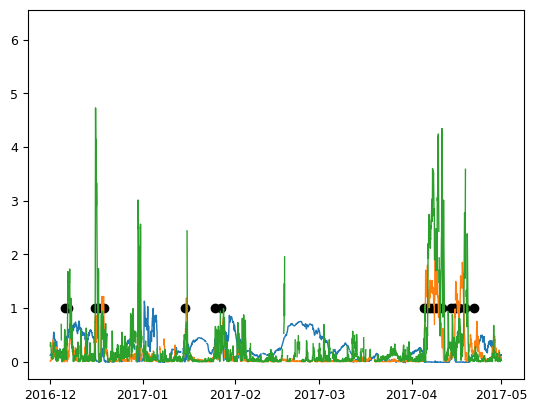

In [174]:
sect = dso.sel(depth=[-39,-16])

dpdz = (sect.sig0.diff('depth') / sect.depth.diff('depth')).squeeze()
N2 = (-9.8/(sect.sig0.mean()+1000))*dpdz


# plt.plot(dpdz.time, dpdz)
plt.plot(dpdz.time,1000*N2)
plt.plot(dpdz.time,1000*lwr_shear**2)
plt.plot(dpdz.time,1000*sfc_shear**2)

# Ri = N2/(sfc_shear**2)

# plt.plot(dpdz.time.resample(time='12H').mean(),Ri.resample(time='12H').mean())
# plt.semilogy()

# plt.axhline(1/4, c='k')

plt.scatter(pd.to_datetime(df.time[(df.extent>0)&time_cond]), 
            np.ones(np.sum((df.extent>0)&time_cond)), c='k')

(0.0, 0.005)

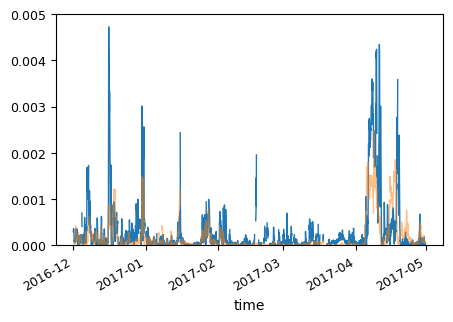

In [175]:
fig, ax= plt.subplots(figsize=(5,3))
# sfc_shear.sel(z=-15.3).plot()
(sfc_shear**2).plot()
(lwr_shear**2).plot(alpha=0.5)

# sfc_shear.sel(z=-15.3).plot()

plt.ylim(0,0.005)

In [176]:
z_vals = [-17.3,-5.3]
# z_vals = [-14,-6]

du = ds.u.sel(depth=z_vals).diff('depth')
dv = ds.v.sel(depth=z_vals).diff('depth')
dz = ds.sel(depth=z_vals).depth.diff('depth').squeeze()
bulkshear = (np.sqrt(du**2+dv**2)/dz).squeeze()

z_vals = [-33.3, -17.3]
# z_vals = [-30, -14]

du = ds.u.sel(depth=z_vals).diff('depth')
dv = ds.v.sel(depth=z_vals).diff('depth')
dz = ds.sel(depth=z_vals).depth.diff('depth').squeeze()
bulkshear_deep = (np.sqrt(du**2+dv**2)/dz).squeeze()

In [177]:
shear = (dU/dz)**2
z_vals = slice(-18,-5)


nanmax = 0.5

nan_frac = np.isnan(shear).sum(dim='depth')/len(ds.depth)

min_shear = shear.sel(depth=z_vals).min('depth')
max_shear = shear.sel(depth=z_vals).max('depth')
mean_shear = shear.sel(depth=z_vals).mean('depth')

min_shear[nan_frac>nanmax] = np.nan
max_shear[nan_frac>nanmax] = np.nan
mean_shear[nan_frac>nanmax] = np.nan

# daily_mean_shear = shear.resample(time='1D').mean()

# daily_min = daily_mean_shear.sel(depth=slice(-16,-4)).min('depth')
# daily_max = daily_mean_shear.sel(depth=slice(-16,-4)).max('depth')
# daily_mean = daily_mean_shear.sel(depth=slice(-16,-4)).mean('depth')



# daily_min = min_shear.resample(time='1D').mean()
# daily_max = max_shear.resample(time='1D').mean()

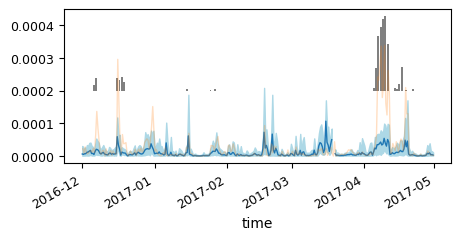

In [178]:
fig, ax= plt.subplots(figsize=(5,2))

ax.bar(pd.to_datetime(df.time[time_cond]), df.extent[time_cond]/20000000,bottom=0.0002, color='gray')

# plt.fill_between(ds.time.resample(time='6H').mean(), min_shear.resample(time='6H').mean(), max_shear.resample(time='6H').mean(), color='lightblue', lw=0)
plt.fill_between(ds.time.resample(time='12H').mean(), 
                 max_shear.resample(time='12H').mean(),
                 min_shear.resample(time='12H').mean(), color='lightblue', lw=1)
mean_shear.resample(time='12H').mean().plot(lw=1)

# plt.plot(sfc_shear.time.resample(time='12H').mean(), sfc_shear.resample(time='12H').mean()**2, alpha=0.25)
plt.plot(sfc_shear.time.resample(time='12H').mean(),0.1*sfc_shear.resample(time='12H').mean()**2, alpha=0.25)
# (0.15*bulkshear.resample(time='12H').mean()).plot(lw=1)

# (0.5*bulkshear).plot(lw=1)

# plt.axhline(0, c='k')
# plt.plot(daily_max.time, daily_mean, color='royalblue', lw=1)
# ax.plot(dt_sfc.time, (dt_sfc/15)+0.05, c='r', lw=0.5,zorder=-1)

In [18]:
len(bulkshear.resample(time='24H').mean('time').values)

151

In [19]:
len(df.extent[time_cond].values)

151

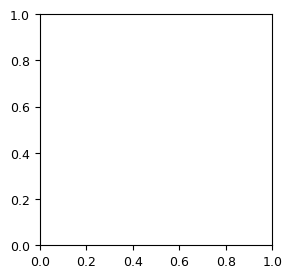

In [20]:
fig, ax= plt.subplots(figsize=(3,3))


# ax.scatter(mean_shear.resample(time='3H').mean(), 
#            dt_sfc.resample(time='3H').mean(), s=1)

lag = 2
# ax.scatter(mean_shear.resample(time='12H').mean()[:-lag], 
#            dt_sfc.resample(time='12H').mean()[lag:], s=5)


# ax.scatter(bulkshear.resample(time='24H').mean('time').values, df.extent[time_cond].values)

# ax.scatter(bulkshear.resample(time='24H').mean('time'), bulkshear_deep.resample(time='24H').mean('time'))


# ax.set_xlim(0,0.05)

In [21]:
var1 = ds.se.mean('depth')
# var2_lagged = (ds6.Ct-ds6.Tf).mean('depth').shift(time=20)

var2_lagged = (ds6.Ct-ds6.Tf).sel(depth=-16).shift(time=20)

# Align time and drop NaNs from shift
valid = var1.notnull() & var2_lagged.notnull()
var1 = var1.where(valid, drop=True)
var2_lagged = var2_lagged.where(valid, drop=True)




NameError: name 'ds6' is not defined

NameError: name 'ds6' is not defined

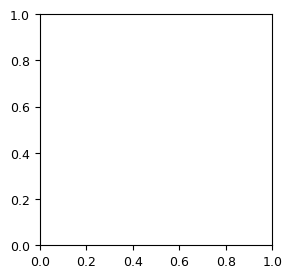

In [22]:
fig, ax = plt.subplots(figsize=(3,3))

ax.scatter(bulkshear, (ds6.Ct-ds6.Tf).mean('depth'), s=5, alpha=0.1)

# ax.scatter(var1.rolling(time=12, center=False).mean(), 
#            var2_lagged.rolling(time=12, center=False).mean(), s=5, alpha=0.1)

In [23]:
(dU/dz)**2

<xarray.DataArray (depth: 15, time: 3624)>
array([[4.16195255e-06, 2.78003207e-06, 8.24777039e-06, ...,
                   nan,            nan,            nan],
       [7.22863821e-06, 1.29461780e-05, 1.02429923e-05, ...,
        4.66500287e-07, 1.51371550e-06, 2.74614055e-06],
       [3.94175924e-06, 4.55692934e-06, 3.09122588e-06, ...,
        1.07757273e-06, 6.69181476e-07, 1.67209993e-08],
       ...,
       [1.05743105e-06, 4.26279444e-07, 8.77017288e-07, ...,
        1.11702912e-06, 1.28661554e-06, 1.72959813e-06],
       [2.10479782e-07, 1.72106827e-08, 4.06293272e-08, ...,
        1.12445613e-06, 2.98641302e-06, 2.11113240e-06],
       [           nan,            nan,            nan, ...,
                   nan,            nan,            nan]])
Coordinates:
  * depth    (depth) float64 -33.3 -31.3 -29.3 -25.3 ... -9.3 -7.3 -5.3 -3.3
  * time     (time) datetime64[ns] 2016-12-01 ... 2017-04-30T23:00:00

NameError: name 'ds6' is not defined

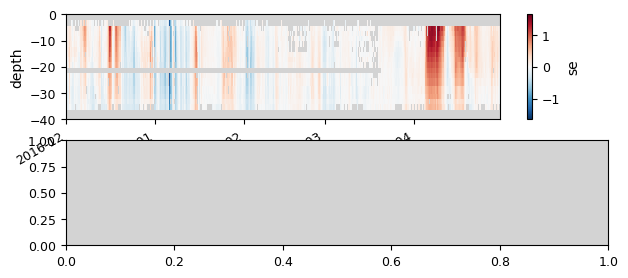

In [24]:
fig,axs=plt.subplots(2,1,figsize=(7,3))
for ax in axs:
    ax.patch.set_facecolor('lightgray')

ax = axs[0]    
ds.se.plot(ax=ax)
ax.set_ylim(-40,0)

ax = axs[1]    
(ds6.Ct-ds6.Tf).plot(ax=ax, vmin=0, vmax=1.5, cmap=cmocean.cm.matter)
ax.set_ylim(-40,0)

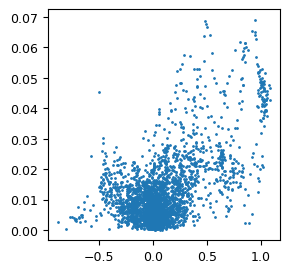

In [27]:
fig,ax=plt.subplots(figsize=(3,3))
# ((dU/dz)**2).mean('depth').plot()

ax.scatter(ds.se.mean('depth'), bulkshear, s=1)

# ds.se.mean('depth').plot()

In [50]:
ds6

NameError: name 'ds6' is not defined

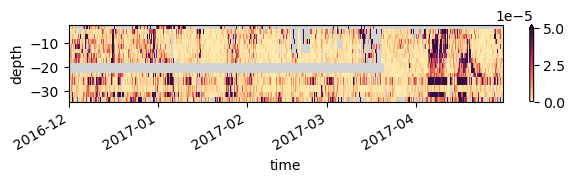

In [41]:
fig,ax=plt.subplots(figsize=(7,1))
ax.patch.set_facecolor('lightgray')
ax.set_ylim(-40,0)
((dU/dz)**2).plot(vmin=0, vmax=0.00005, cmap=cmocean.cm.matter)

(-30.0, 5.0)

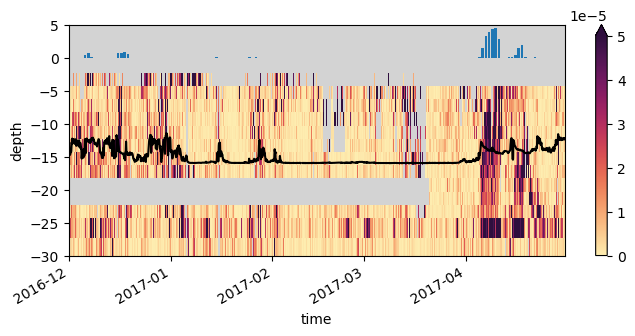

In [476]:
fig, ax= plt.subplots(figsize=(8,3))
ax.patch.set_facecolor('lightgray')
ax.bar(pd.to_datetime(df.time[time_cond]), df.extent[time_cond]/1000)
((dU/dz)**2).plot(vmin=0, vmax=0.00005, cmap=cmocean.cm.matter)

# dUi.plot(vmin=0, vmax=1)

plt.plot(dt_sfc.time, (3*dt_sfc)-16, c='k')
ax.set_ylim(-30,5)

(-30.0, 5.0)

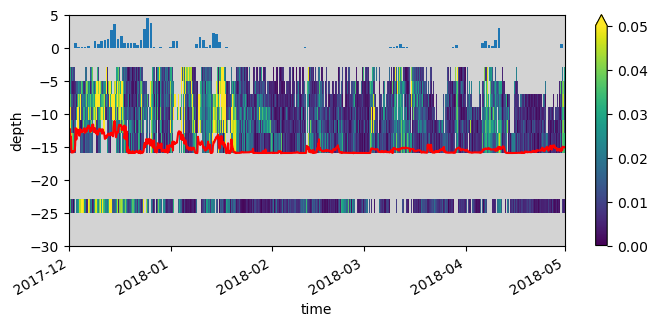

In [77]:
fig, ax= plt.subplots(figsize=(8,3))
ax.patch.set_facecolor('lightgray')
ax.bar(pd.to_datetime(df.time[time_cond]), df.extent[time_cond]/1000)
(dU/dz).plot(vmin=0, vmax=0.05)

# dUi.plot(vmin=0, vmax=1)

plt.plot(dt_sfc.time, (3*dt_sfc)-16, c='r')
ax.set_ylim(-30,5)

In [28]:
def open_mooring_files(time_range, mooring = 'M1'):

    open_years = f'{time_range.start.year}_{time_range.stop.year}'

    # polynya area
    df = pd.read_csv('../data/compiled_stats.csv')
    last_days = df.time[(df.final_day)&(df.single_day==False)].values


    DS = xr.open_dataset(f'../data/polynya_size/daily_polynya_{time_range.stop.year}_sic10_v7.2_radius25km.nc')
    DS = DS.sel(time = time_range)
    DS['width'] = (DS['w_max'] - DS['w_min'])

    # ocean velocity
    #-----------------
    ds = xr.open_dataset(f"/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/{mooring}/{mooring}_hourly_ocean_currents_{open_years}.nc")
    ds.close()
    ds = ds.sel(time=time_range)
    ds['se'] = vectors.comp_along_theta(ds.u, ds.v, 145*units('deg'))
    ds['ne'] = vectors.comp_along_theta(ds.u, ds.v, (90+145)*units('deg'))
    ds['speed'] = np.sqrt(ds.u**2+ ds.v**2)
    
    # ocean temperature, sailinity
    #-----------------------------
    ds2 = xr.open_dataset(f"/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/{mooring}/{mooring}_hourly_tempsalinity_{open_years}.nc")
    ds2.close()
    
    ds2['dT'] = ds2.Ct - ds2.Tf
    
    # find seasonal sigma
    smooth_sfc_sig = tseries.running_mean(ds2.sig0.sel(depth=-16).values, length=24*30, center=True, address_nans=True)
    smooth_bot_sig = tseries.running_mean(ds2.sig0.sel(depth=ds2.depth.min()).values, length=24*30, center=True, address_nans=True)
    smooth_dma_sig = tseries.running_mean(ds2.sig0.mean('depth').values, length=24*30, center=True, address_nans=True)
    ds2 = ds2.assign({"lowpass_sfc_sig": ( ("time"),  smooth_sfc_sig)})
    ds2 = ds2.assign({"lowpass_dma_sig": ( ("time"),  smooth_dma_sig)})
    ds2 = ds2.assign({"lowpass_bot_sig": ( ("time"),  smooth_bot_sig)})
    
    ds2 = ds2.sel(time=time_range)


    # sea ice velocity
    #------------------
    ds3 = xr.open_dataset(f"/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/{mooring}/{mooring}_hourly_seaice_velocity_{open_years}.nc")
    ds3.close()
    ds3 = ds3.sel(depth=0, time=time_range)
    ds3['se'] = vectors.comp_along_theta(ds3.u, ds3.v, 145*units('deg'))
    ds3['speed'] = np.sqrt(ds3.u**2+ ds3.v**2)
    ds3['angle'] = vectors.vector_angle(ds3.u.values, ds3.v.values).magnitude

    # heat flux
    #------------------
#     ds6 = xr.open_dataset(f'../data/heat_flux/ohf_{time_range.stop.year}_v0.nc')
#     ds6 = ds6.sel(time=time_range)
#     ds6.close()

    # hourly winds
    #-------------------
    filename = f"../data/forcing/regional_hourly_era_{time_range.stop.year}_v7.nc"
    dse = xr.open_dataset(filename).sel(time=time_range)
    dse['angle'] = vectors.vector_angle(dse.u10.values, dse.v10.values).magnitude
    dse['speed'] = np.sqrt(dse.u10.values**2 + dse.v10.values**2)


    
    data = {}
    data['dsi'] = ds3   # sea ice velocity
    data['dso'] = ds    # ocean velocity
    data['dsp'] = ds2   # ocean properties
#     data['dsh'] = ds6  # ocean heat transport
    data['dsw'] = dse   # wind velocity
    
    
    # up-sample polynya extents to hourly to match other data
    dates = np.array([], dtype=np.datetime64)
    total_open = np.array([])
    extents = np.array([])
    length_145s = np.array([])
    length_maxs = np.array([])
    com_directions = np.array([])
    max_length_directions = np.array([])
    widths = np.array([])

    for dd, date in enumerate(pd.to_datetime(DS.time)):
        for ii in range(24):
            dates = np.append(dates, date + timedelta(hours=ii))
            extents = np.append(extents, DS.polynya_extent[dd])
            total_open = np.append(total_open, DS.polynya_extent[dd]+DS.other_polynya_extent[dd])
            length_145s = np.append(length_145s, DS.l_max[dd])
            length_maxs = np.append(length_maxs, DS.max_length[dd])
            com_directions = np.append(com_directions, DS.com_direction[dd])
            max_length_directions = np.append(max_length_directions, DS.max_length_direction[dd])
            widths = np.append(widths, DS.width[dd])
    length_145s[np.isnan(length_145s)] = 0
    length_maxs[np.isnan(length_maxs)] = 0
    widths[np.isnan(widths)] = 0
    com_directions[np.isnan(com_directions)] = 0
    max_length_directions[np.isnan(max_length_directions)] = 0
    
    data['time'] = dates
    data['length_145'] = length_145s
    data['length_maxs'] = length_maxs
    data['com_directions'] = com_directions
    data['max_length_directions'] = max_length_directions
    data['extent'] = extents
    data['total_open'] = total_open
    data['width'] = widths
    
    
    data['month'] = np.array([date.month for date in dates])
    
    
    # sea ice velocity
    data['ice_se'] = ds3.se.values                # se sea ice velocity
    data['ui'] = ds3.u.values               
    data['vi'] = ds3.v.values                
    data['dma_se'] = ds.mean('depth').se.values   # depth mean se ocean current
    data['sfc_se'] = ds.se.sel(depth=-10, method='nearest').values   # sfc. current, for now just use closest to 10m
    data['uo'] = ds.mean('depth').u.values              
    data['vo'] = ds.mean('depth').v.values        
    
    data['sfc_dt'] = ds2.sel(depth=-16).dT.values # surface temp
    data['dma_dt'] = ds2.mean('depth').dT.values  # surface temp
    
    data['sfc_ct'] = ds2.sel(depth=-16).Ct.values # surface temp
    data['dma_ct'] = ds2.mean('depth').Ct.values  # surface temp
    
    data['sfc_sig'] = ds2.sel(depth=-16).sig0.values 
    data['dma_sig'] = ds2.mean('depth').sig0.values
    data['bot_sig'] = ds2.sig0.sel(depth=ds2.depth.min()).values
    
    data['lp_sfc_sig'] = ds2.lowpass_sfc_sig.values
    data['lp_dma_sig'] = ds2.lowpass_dma_sig.values 
    data['lp_bot_sig'] = ds2.lowpass_bot_sig.values 

    
    data['sfc_sal'] = ds2.sel(depth=-16).Sa.values
    data['dma_sal'] = ds2.mean('depth').Sa.values 
    
    data['u10'] = data['dsw'].u10.values
    data['v10'] = data['dsw'].v10.values
    data['s10'] = np.sqrt(data['dsw'].u10.values**2 + data['dsw'].v10.values**2)
    
    
    
    # open IHT
    open_years = f'{time_range.start.year}_{time_range.stop.year}'

    ds6 = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/{mooring}/regridded/{mooring}_OHT_{open_years}_v1.nc')
    
    ds6 = ds6.sel(time = time_range)
    
    mean_dt = (ds6.Ct-ds6.Tf).mean('z')
    mean_sig = ds6.sig0.mean('z')
    DT = (ds6.Ct-ds6.Tf) * units('delta_degC')
    SIG = ds6.sig0 * units('kg/m3')
    U = vectors.comp_along_theta(ds6.u, ds6.v, 145*units('degree'))* units('m/s')

    ht_perm3 = cst['Cp_o']*DT*SIG*U
    hc_perm3 = cst['Cp_o']*DT*SIG
    dz = ds6.z.diff('z').values[0] * units('m')

    IHT = 0.5*np.sum(ht_perm3[:-1, :].values + ht_perm3[1:, :].values, axis=0) *units('joule/m2/s') * dz
    IHC = 0.5*np.sum(hc_perm3[:-1, :].values + hc_perm3[1:, :].values, axis=0) *units('joule/m3') * dz

#     hc_event = hc_perm3.sel(time=time_range)
#     IHC_event = 0.5*np.sum(hc_event[:-1, :].values + hc_event[1:, :].values, axis=0) *units('joule/m3') * dz

    daily_mean_IHT = np.copy(IHT)
    for ii in range(0,len(IHT), 24):
        daily_mean_IHT[ii:ii+24] = np.mean(daily_mean_IHT[ii:ii+24])

    data['IHC'] = IHC
    data['IHT'] = IHT
    data['daily_mean_IHT'] = daily_mean_IHT
    
    
    # sfc heat content only
    ds6 = ds6.sel(z=slice(-16,0))
    mean_dt = (ds6.Ct-ds6.Tf).mean('z')
    mean_sig = ds6.sig0.mean('z')
    DT = (ds6.Ct-ds6.Tf) * units('delta_degC')
    SIG = ds6.sig0 * units('kg/m3')
    U = vectors.comp_along_theta(ds6.u, ds6.v, 145*units('degree'))* units('m/s')

    ht_perm3 = cst['Cp_o']*DT*SIG*U
    hc_perm3 = cst['Cp_o']*DT*SIG
    dz = ds6.z.diff('z').values[0] * units('m')
    IHT = 0.5*np.sum(ht_perm3[:-1, :].values + ht_perm3[1:, :].values, axis=0) *units('joule/m2/s') * dz
    IHC = 0.5*np.sum(hc_perm3[:-1, :].values + hc_perm3[1:, :].values, axis=0) *units('joule/m3') * dz

    data['IHC_sfc'] = IHC
    data['IHT_sfc'] = IHT
    
    
    
    return data
    
    
def add_events_to_dict(data):
    
    data['event_num'] = np.full(len(data['time']), -999)
    data['event_hour'] = np.full(len(data['time']), -999)
    data['after_hour'] = np.full(len(data['time']), -999)
    data['before_hour'] = np.full(len(data['time']), -999)

    data['after_num'] = np.full(len(data['time']), -999)
    data['before_num'] = np.full(len(data['time']), -999)

    # flow_events = tseries.dates_to_sequences(data['time'][data['dma_se']>0.2], dt_max=3*units('hour'))
    flow_events = tseries.dates_to_sequences(data['time'][data['extent']>0], dt_max=3*units('hour'))

    # flow_events = tseries.dates_to_sequences(data['time'][data['dsw'].u10<0], dt_max=3*units('hour'))

    data['flow_events'] = flow_events
    
    
    
    for ff in flow_events:

        ti = np.where(data['time'] == flow_events[ff][0])[0][0]
        tf = np.where(data['time'] == flow_events[ff][-1])[0][0]
        data['event_hour'][ti:tf+1] = np.arange(len(data['time'][ti:tf+1]))
        data['event_num'][ti:tf+1] = np.full(len(data['time'][ti:tf+1]), ff)

    for ff in flow_events.keys():

        ti = np.where(data['event_num'] == ff)[0][0]
        tf = np.where(data['event_num'] == ff)[0][-1]

        counter = 1
        for ii in range(tf+1, len(data['time'])):
            if data['event_hour'][ii] != -999:
                break

            else:
                data['after_hour'][ii] = counter
                data['after_num'][ii] = ff
                counter+=1

        counter = -1
        for ii in range(0, ti)[::-1]:
            if data['event_hour'][ii] != -999:
                break

            else:
                data['before_hour'][ii] = counter
                data['before_num'][ii] = ff
                counter-=1
        
    return data

def interp_velocities(data): 
    
    data['ice_se'], _ = tseries.linear_interpolate(data['time'], data['time'], data['ice_se'], max_dt=6*units('hours'))
    data['ice_se'][np.isnan(data['ice_se'])] = 0 # first and last few values are nans, just replace with zeros
    
    data['ui'], _ = tseries.linear_interpolate(data['time'], data['time'], data['ui'], max_dt=6*units('hours'))
    data['ui'][np.isnan(data['ui'])] = 0 # first and last few values are nans, just replace with zeros

    data['vi'], _ = tseries.linear_interpolate(data['time'], data['time'], data['vi'], max_dt=6*units('hours'))
    data['vi'][np.isnan(data['vi'])] = 0 # first and last few values are nans, just replace with zeros

    
    data['sfc_se'], _ = tseries.linear_interpolate(data['time'], data['time'], data['sfc_se'], max_dt=6*units('hours'))
    data['sfc_se'][np.isnan(data['sfc_se'])] = 0 # first and last few values are nans, just replace with zeros

    data['dma_se'], _ = tseries.linear_interpolate(data['time'], data['time'], data['dma_se'], max_dt=6*units('hours'))
    data['dma_se'][np.isnan(data['dma_se'])] = 0 # first and last few values are nans, just replace with zeros

    data['uo'], _ = tseries.linear_interpolate(data['time'], data['time'], data['uo'], max_dt=6*units('hours'))
    data['uo'][np.isnan(data['uo'])] = 0 # first and last few values are nans, just replace with zeros

    data['vo'], _ = tseries.linear_interpolate(data['time'], data['time'], data['vo'], max_dt=6*units('hours'))
    data['vo'][np.isnan(data['vo'])] = 0 # first and last few values are nans, just replace with zeros

    
    
    data['sfc_dt'], _ = tseries.linear_interpolate(data['time'], data['time'], data['sfc_dt'], max_dt=24*units('hours'))
    data['sfc_dt'][np.isnan(data['sfc_dt'])] = 0 # first and last few values are nans, just replace with zeros

    data['sfc_sig'], _ = tseries.linear_interpolate(data['time'], data['time'], data['sfc_sig'], max_dt=24*units('hours'))
    data['sfc_sig'][np.isnan(data['sfc_sig'])] = 0 # first and last few values are nans, just replace with zeros

    data['dma_dt'], _ = tseries.linear_interpolate(data['time'], data['time'], data['dma_dt'], max_dt=24*units('hours'))
    data['dma_dt'][np.isnan(data['dma_dt'])] = 0 # first and last few values are nans, just replace with zeros

    data['dma_sig'], _ = tseries.linear_interpolate(data['time'], data['time'], data['dma_sig'], max_dt=24*units('hours'))
    data['dma_sig'][np.isnan(data['dma_sig'])] = 0 # first and last few values are nans, just replace with zeros

    
    return data

In [29]:
# time_ranges = [slice(datetime(2016, 12, 1), datetime(2017, 4, 30,23)),
#                   slice(datetime(2017, 12, 1), datetime(2018, 4, 30,23)),
#                   slice(datetime(2018, 12, 1), datetime(2019, 2, 10,23))]

time_ranges = [slice(datetime(2016, 12, 1), datetime(2017, 4, 30,23)),
                  slice(datetime(2017, 12, 1), datetime(2018, 4, 30,23))]


#                   slice(datetime(2018, 12, 1), datetime(2019, 1,31,23))
# time_ranges = [slice(datetime(2016, 12, 1), datetime(2017, 4, 30,23)),
#                   slice(datetime(2017, 12, 1), datetime(2018, 4, 30,23)),
#                   slice(datetime(2018, 12, 1), datetime(2019, 4, 30,23))]

In [30]:
# find variance ellipses

xp = all_uo[all_extents>0]
yp = all_vo[all_extents>0]

varell = tanalyze.variance_ellipses(xp,yp)
xm = vectors.comp_along_theta(xp, yp, varell['theta_m'] * units('rad'))
ym = vectors.comp_along_theta(xp, yp, (varell['theta_m']+np.pi/2) * units('rad'))


NameError: name 'all_uo' is not defined

In [15]:
np.sum(all_dma_se[all_extents>0])

0.0

In [16]:
np.sum(all_dma_se)

0.0

In [27]:
np.sum(all_dma_se[(all_extents>0)&(all_dma_se>0)])

0.0

In [28]:
np.sum(all_dma_se[(all_dma_se>0)])

0.0

In [29]:
1024.834619301936/1313.9576011253996

0.7799601892969523

nan degree


/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_33677/4171324219.py:7: RuntimeWarning: Mean of empty slice
  plt.quiver(np.array([0]), np.array([0]), np.nanmean(xp), np.nanmean(yp), angles='xy', scale_units='xy', scale=1)
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_33677/4171324219.py:9: RuntimeWarning: Mean of empty slice
  print(vectors.vector_angle(np.nanmean(xp), np.nanmean(yp)))


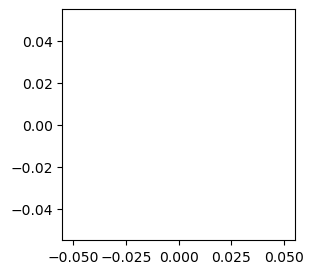

In [30]:
fig, ax = plt.subplots(figsize=(3,3))

ax.plot(varell['xe'], varell['ye'])

# plt.quiver(np.array([0]), np.array([0]), varell['sxx'], varell['syy'])

plt.quiver(np.array([0]), np.array([0]), np.nanmean(xp), np.nanmean(yp), angles='xy', scale_units='xy', scale=1)

print(vectors.vector_angle(np.nanmean(xp), np.nanmean(yp)))

In [31]:
(90-vectors.vector_angle(np.nanmean(xp), np.nanmean(yp)).magnitude) + 360

/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_33677/492671477.py:1: RuntimeWarning: Mean of empty slice
  (90-vectors.vector_angle(np.nanmean(xp), np.nanmean(yp)).magnitude) + 360


nan

In [41]:
(90-143.87463005850987) + 360

306.12536994149013

In [42]:
(90-(180+varell['theta_m'] * units('rad').to('degree').magnitude))+ 360

299.517032728883

In [20]:
varell['theta_m'] * units('rad').to('degree')

<Quantity(-33.6935826, 'degree')>

In [21]:
(90-(-33.693582581020))

123.69358258102

In [97]:
all_extents = np.array([])
all_openext = np.array([])
all_length_145s = np.array([])
all_length_maxs = np.array([])
all_poly_dirs = np.array([])
all_poly_mldirs = np.array([])

all_widths = np.array([])
all_daily_lengths = np.array([])
all_daily_IHT = np.array([])
all_years = np.array([])
all_times = np.array([], dtype=np.datetime64)
all_sfc_T = np.array([])
all_sfc_sal = np.array([])
all_dma_sig = np.array([])
all_bot_sig = np.array([])
all_sfc_sig = np.array([])
all_lp_dma_sig = np.array([])
all_lp_sfc_sig = np.array([])
all_lp_bot_sig = np.array([])

all_dma_T = np.array([])
all_dma_se = np.array([])
all_ice_se = np.array([])
all_IHT = np.array([])
all_IHC = np.array([])
all_IHT_sfc = np.array([])
all_IHC_sfc = np.array([])
all_months = np.array([])
all_doy = np.array([])
all_u10 = np.array([])
all_v10 = np.array([])

all_ui = np.array([])
all_vi = np.array([])

all_uo = np.array([])
all_vo = np.array([])

for time_range, color in zip(time_ranges, ['royalblue', 'orange', 'gold']):
    
    data = open_mooring_files(time_range, mooring = 'M1')
    data = interp_velocities(data)
    
    all_times=np.append(all_times, data['time'])
    
    all_sfc_T = np.append(all_sfc_T, data['sfc_dt'])
    all_sfc_sal = np.append(all_sfc_sal, data['sfc_sal'])
    all_sfc_sig = np.append(all_sfc_sig, data['sfc_sig'])
    all_dma_sig = np.append(all_dma_sig, data['dma_sig'])
    all_bot_sig = np.append(all_bot_sig, data['bot_sig'])
    
    all_lp_dma_sig = np.append(all_lp_dma_sig, data['lp_dma_sig'])
    all_lp_sfc_sig = np.append(all_lp_sfc_sig, data['lp_sfc_sig'])
    all_lp_bot_sig = np.append(all_lp_bot_sig, data['lp_bot_sig'])
    
    
    all_dma_T = np.append(all_dma_T, data['dma_dt'])
    all_dma_se = np.append(all_dma_se, data['dma_se'])
    
    all_ice_se = np.append(all_ice_se, data['ice_se'])
    all_ui = np.append(all_ui, data['ui'])
    all_vi = np.append(all_vi, data['vi'])
    
    all_uo = np.append(all_uo, data['uo'])
    all_vo = np.append(all_vo, data['vo'])
    
    all_u10 = np.append(all_u10, data['u10'])
    all_v10 = np.append(all_v10, data['v10'])
    
    all_extents = np.append(all_extents, data['extent'])
    all_length_145s = np.append(all_length_145s, data['length_145'])
    all_length_maxs = np.append(all_length_maxs, data['length_maxs'])
    all_poly_dirs = np.append(all_poly_dirs, data['com_directions'])
    all_poly_mldirs = np.append(all_poly_mldirs, data['max_length_directions'])
    all_openext = np.append(all_openext, data['total_open'])
    
    all_widths = np.append(all_widths, data['width'])
    all_daily_lengths = np.append(all_daily_lengths, data['length_145'][::24])
    all_daily_IHT = np.append(all_daily_IHT, data['daily_mean_IHT'][::24])
    all_IHT = np.append(all_IHT, data['IHT'])
    all_IHC = np.append(all_IHC, data['IHC'])
    all_IHT_sfc = np.append(all_IHT_sfc, data['IHT_sfc'])
    all_IHC_sfc = np.append(all_IHC_sfc, data['IHC_sfc'])
    all_months = np.append(all_months, data['month'])

    

    doy = np.array([(time - datetime(data['time'][-1].year, 1,1)).total_seconds()/(24*60*60) for time in data['time']])
    all_doy = np.append(all_doy, doy)
    
    all_years = np.append(all_years, np.full(len(data['length_145']),time_range.stop.year))

all_times = pd.to_datetime(all_times)
all_ese10 = vectors.comp_along_theta(all_u10, all_v10, 145*units('degree'))

In [32]:
def dir_conds(dff, cat):
    
    if cat == 'wind':
        dir_cond = (dff['a10_r'] > 260) & (dff['a10_r'] < 305)
        
    elif cat == 'ice':
        
        dir_cond = (dff['ai_r'] > 270) & (dff['ai_r'] < 315)
    return dir_cond

def speed_conds(dff, cat):
    
    if cat == 'wind':
        speed_cond = (dff['s10'] > 7.5)
    elif cat == 'ice':
        speed_cond = (dff['si_km'] > 12)
    return speed_cond

<>:131: SyntaxWarning: invalid escape sequence '\m'
<>:184: SyntaxWarning: invalid escape sequence '\m'
<>:189: SyntaxWarning: invalid escape sequence '\m'
<>:199: SyntaxWarning: invalid escape sequence '\m'
<>:131: SyntaxWarning: invalid escape sequence '\m'
<>:184: SyntaxWarning: invalid escape sequence '\m'
<>:189: SyntaxWarning: invalid escape sequence '\m'
<>:199: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_87344/3344298040.py:131: SyntaxWarning: invalid escape sequence '\m'
  cb_ticklabels='auto', cb_extend='neither', cb_label='$\mathrm{T-T_{f}\;(^{\circ}C)}$', labelpad=10,
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_87344/3344298040.py:184: SyntaxWarning: invalid escape sequence '\m'
  axs[N,0].set_ylabel('Easterly\nwind\n$\mathrm{(m\;{s}^{-1})}$', rotation=0, labelpad=20, va='center')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_87344/3344298040.py:189: SyntaxWarning: invalid escape sequence

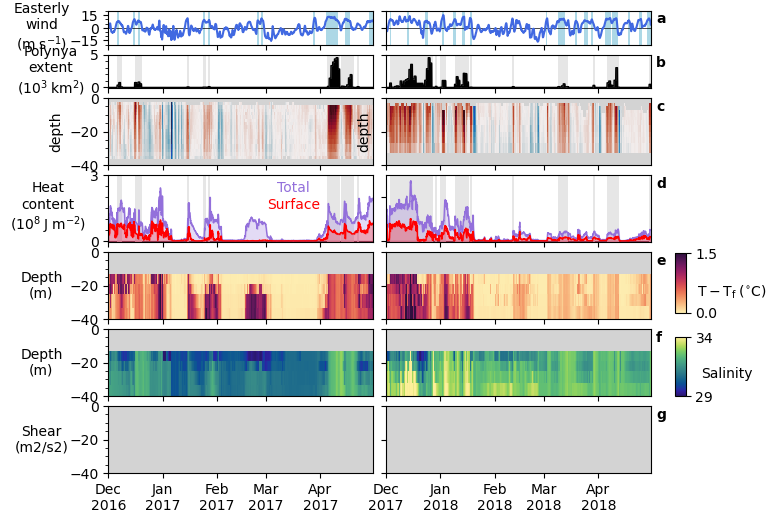

In [113]:
fig, axs = plt.subplots(7,2,figsize=(7,6), gridspec_kw={'height_ratios':[0.5,0.5,1,1,1,1,1], })


for ax, year in zip(axs[0,:], [2017, 2018]):
    ax.set_ylim(-20,20)
    
    time_cond = (all_years==year)
    
    COND = (df.year==year)
    
#     ax.plot(pd.to_datetime(df['time'][COND].values), -df['u10'][COND])
    ax.plot(all_times[time_cond], -all_u10[time_cond],  alpha=1, lw=1.5, c='royalblue')
    
    
    COND = (dir_conds(df, 'wind')&speed_conds(df, 'wind'))&(df.year==year)
    for time in pd.to_datetime(df['time'][COND].values):
#         ax.axvline(time, lw=0.5, color='b', zorder=-1000)
        ax.axvspan(time, time+timedelta(hours=24), ymin=-20, ymax=20, lw=0, color='lightblue', zorder=-1)
    ax.axhline(0, c='k', lw=0.5, zorder=-1)

    
# # for ax, year in zip(axs[1,:], [2017, 2018]):
# #     time_cond = (all_years==year)

# #     ax.set_ylim(-40,40)
# #     ax.set_xlim(datetime(year-1,12,1), datetime(year,4,30,23))
    
# #     COND = (df.year==year)
    
# #     ax.plot(pd.to_datetime(df['time'][COND].values), df['alongi_km'][COND])
    
# #     COND = (dir_conds(df, 'ice')&speed_conds(df, 'ice'))&(df.year==year)
# #     for time in pd.to_datetime(df['time'][COND].values):
# # #         ax.axvline(time, lw=0.5, color='b', zorder=-1000)
# #         ax.axvspan(time, time+timedelta(hours=24), ymin=-20, ymax=20, lw=0, color='lightblue', zorder=-1)
# #     ax.axhline(0, c='k', lw=0.5, zorder=-1)


# # axs[1,0].set_ylabel('Alongshore\nice drift\n$\mathrm{(km\;{d}^{-1})}$')


# polynya extent
#---------------
for ax, year in zip(axs[1,:], [2017, 2018]):    
    time_cond = (all_years==year)
    ax.set_ylim(-0.1,5)
    ax.fill_between(all_times[time_cond], all_extents[time_cond]/1000,0, lw=0, color='k')
    ax.plot(all_times[time_cond], all_extents[time_cond]/1000, color='k', lw=1)

#     ax.bar(all_times[time_cond], all_extents[time_cond]/1000, lw=0, color='k')
    
    

#     ax.set_ylim(-5,220)
#     ax.fill_between(all_times[time_cond], all_length_145s[time_cond],0, lw=0, color='k')
#     ax.plot(all_times[time_cond], all_length_145s[time_cond], color='k', lw=1)

    
    
for ax, year in zip(axs[3,:], [2017, 2018]):
    time_cond = (all_years==year)
    
    ax.axhline(0, c='k',lw=0.5,  zorder=-2)
#     ax.plot(all_times[time_cond], all_IHT[time_cond].magnitude/1e8, zorder=0, c='r', alpha=0.5)
#     ax.step(all_times[time_cond][::24], daily_mean_IHC[time_cond[::24]].magnitude/1e8, where='post', zorder=1, color='r', lw=1.5)
#     ax.fill_between(all_times[time_cond][::24], 0, daily_mean_IHC[time_cond[::24]].magnitude/1e8, step='post', alpha=0.25, color='r')

    ax.plot(all_times[time_cond], all_IHC[time_cond].magnitude/1e8, zorder=1, color='mediumpurple', lw=1)
    ax.fill_between(all_times[time_cond], 0, all_IHC[time_cond].magnitude/1e8, alpha=0.25, color='mediumpurple')
    
    ax.plot(all_times[time_cond], all_IHC_sfc[time_cond].magnitude/1e8, zorder=1, color='r', lw=1)
    ax.fill_between(all_times[time_cond], 0, all_IHC_sfc[time_cond].magnitude/1e8, alpha=0.25, color='r')
    
    ax.set_ylim(-0.05,3)
    
    
        
            
for JJ in [1,3]:
    for ax, year in zip(axs[JJ,:], [2017, 2018]):    
        for time in all_times[(all_extents>0)&(all_years==year)][::24]:
#             ax.axvline(time, lw=0.5, color=[0.9,0.9,0.9], zorder=-1000)
            ax.axvspan(time, time+timedelta(hours=24), ymin=-20, ymax=20, lw=0, color=[0.9,0.9,0.9], zorder=-1)



for ax, year, dst in zip(axs[2,:], [2017, 2018], [ds, ds2]):
    ax.patch.set_facecolor('lightgray')
    
    DST_interp = dst.interpolate_na(dim='depth', method='linear', max_gap=20)
    DST_interp = DST_interp.interpolate_na(dim='time', method='linear', max_gap='24H')
    DST_interp.se.plot(ax=ax, vmin=-1.5, vmax=1.5, cmap=cmocean.cm.balance, add_colorbar=False)
    ax.set_ylim(-40,0)
    
#     ax.axhline(0, c='k', lw=0.5, zorder=-1)
#     ax.set_ylim(-1.5,1.75)
    
#     time_cond = (all_years==year)
    
#     ax.plot(all_times[time_cond], 
#             -all_u10[time_cond], c='gray', alpha=1, lw=1.5)
    
#     ax.plot(all_times[time_cond], 
#             all_v10[time_cond], c='k', alpha=1, lw=0.5)
#     ax.plot(all_times[time_cond], 
#             all_dma_se[time_cond]*units('m/s').magnitude, c='k', lw=1.5)

    
# ax.text(0.95,0.95, '$\mathrm{Easterly\;wind \;(m\;{s}^{-1})}$', c='gray', ha='right', va='top', transform=ax.transAxes)
# ax.text(0.95,0.15, '$\mathrm{Shelf\;current \;(*10 m\;{s}^{-1})}$', c='dodgerblue', ha='right', va='top', transform=ax.transAxes)
        
    
    
for ax in axs[4:].ravel():
    ax.set_ylim(-40,0)
    ax.patch.set_facecolor('lightgray')
# for ax in axs[4:, 1]:
#     ax.set_ylim(-40,-15)
#     ax.patch.set_facecolor('lightgray')
    
ax = axs[4][0]
ax.pcolormesh(ds6.time, ds6.depth, 
              (ds6.Ct-ds6.Tf).interpolate_na(dim='time', method='linear', max_gap='24H'), vmin=0, vmax=1.5, cmap=cmocean.cm.matter)
# plt.legend()

ax = axs[4][1]
mesh = ax.pcolormesh(dss.time, dss.depth, 
                     (dss.Ct-dss.Tf).interpolate_na(dim='time', method='linear', max_gap='24H'), vmin=0, vmax=1.5, cmap=cmocean.cm.matter)
plotter.add_colorbar(fig, ax, [mesh], cb_placement='right', cb_orientation='vertical', 
                     cb_width=0.015, cb_length_fraction=[0.1, 1], cb_pad=0.035, cb_ticks=[0,1.5], 
                     cb_ticklabels='auto', cb_extend='neither', cb_label='$\mathrm{T-T_{f}\;(^{\circ}C)}$', labelpad=10, 
                     cb_label_placement='auto', cb_tick_placement='auto', tick_kwargs=None, 
                     cb_labelsize=plt.rcParams["font.size"], draw_edges=False, edge_params=['k', 2])



ax = axs[5][0]
ax.pcolormesh(ds6.time, ds6.depth, 
              ds6.Sp.interpolate_na(dim='time', method='linear', max_gap='24H'), vmin=29, vmax=34, cmap=cmocean.cm.haline)

ax = axs[5][1]
# for depth, color in zip([-28,-22,-16], ['mediumpurple', 'dodgerblue', 'k']):
#     ax.plot(dss.time[::sp], (dss.Sp).sel(depth=depth)[::sp], c=color, lw=1.5)
cmesh = ax.pcolormesh(dss.time, dss.depth, 
                      dss.Sp.interpolate_na(dim='time', method='linear', max_gap='24H'), vmin=29, vmax=34, cmap=cmocean.cm.haline) 
plotter.add_colorbar(fig, ax, [cmesh], cb_placement='right', cb_orientation='vertical', 
                     cb_width=0.015, cb_length_fraction=[0., 0.9], cb_pad=0.035, cb_ticks=[29,34], 
                     cb_ticklabels='auto', cb_extend='neither', cb_label='Salinity', labelpad=10, 
                     cb_label_placement='auto', cb_tick_placement='auto', tick_kwargs=None, 
                     cb_labelsize=plt.rcParams["font.size"], draw_edges=False, edge_params=['k', 2])

    
for ax in axs[:,1]:
    ax.set_yticklabels([])
    
# for ax in axs[-2:,0]:
#     ax.set_yticklabels([])
    
plt.subplots_adjust(wspace = 0.05, hspace=0.175)


        
for ax in axs[:,0]:
    year = 2017
    ax.set_xlim(datetime(year-1,12,1), datetime(year,4,30,23))
for ax in axs[:,1]:
    year = 2018
    ax.set_xlim(datetime(year-1,12,1), datetime(year,4,30,23))

for ax in axs.ravel():
    locator = mdates.MonthLocator() # Create a MonthLocator object
    ax.xaxis.set_major_locator(locator) # Set the major locator to monthly
    formatter = mdates.DateFormatter('%b\n%Y') # Define the format (e.g., YYYY-MM)
    ax.xaxis.set_major_formatter(formatter) # Apply the formatter
    
for ax in axs.ravel()[:-2]:
    ax.set_xticklabels([])
    
for aa, ax in enumerate(axs[:,1]):
    ax.text(1.02, 0.975, f'{chr(97+aa)}', weight='bold', ha='left', va='top',  transform=ax.transAxes, clip_on=False)    
    
    
N=0
axs[N,0].set_ylabel('Easterly\nwind\n$\mathrm{(m\;{s}^{-1})}$', rotation=0, labelpad=20, va='center')
axs[N,0].yaxis.set_major_locator(MultipleLocator(15))
axs[N,0].yaxis.set_minor_locator(MultipleLocator(5))

N = 1
axs[N,0].set_ylabel('Polynya\nextent\n$\mathrm{(10^{3}\;{km}^{2})}$', rotation=0, labelpad=28, va='center')  
axs[N,0].yaxis.set_major_locator(MultipleLocator(5))
axs[N,0].yaxis.set_minor_locator(MultipleLocator(1))

N = 2
# axs[N,0].set_ylabel('Shelf\ncurrent\n$\mathrm{(m\;{s}^{-1})}$', rotation=0, labelpad=23, va='center') 
axs[N,0].yaxis.set_major_locator(MultipleLocator(20))
axs[N,0].yaxis.set_minor_locator(MultipleLocator(5))

N = 3
axs[N,0].set_ylabel('Heat\ncontent\n$\mathrm{(10^{8}\;J\;{m}^{-2})}$', rotation=0, labelpad=30, va='center')  
axs[N,0].text(0.7, 0.75, 'Total', ha='center', c='mediumpurple', transform=axs[3,0].transAxes)
axs[N,0].text(0.7, 0.5, 'Surface',ha='center',  c='r', transform=axs[3,0].transAxes)
axs[N,0].yaxis.set_major_locator(MultipleLocator(3))
axs[N,0].yaxis.set_minor_locator(MultipleLocator(0.5))

N = 4
axs[N,0].set_ylabel('Depth\n(m)', rotation=0, labelpad=20, va='center')
axs[N,0].yaxis.set_major_locator(MultipleLocator(20))
axs[N,0].yaxis.set_minor_locator(MultipleLocator(5))

N = 5
axs[N,0].set_ylabel('Depth\n(m)', rotation=0, labelpad=20, va='center')
axs[N,0].yaxis.set_major_locator(MultipleLocator(20))
axs[N,0].yaxis.set_minor_locator(MultipleLocator(5))


N = 6
axs[N,0].set_ylabel('Shear\n(m2/s2)', rotation=0, labelpad=20, va='center')
axs[N,0].yaxis.set_major_locator(MultipleLocator(20))
axs[N,0].yaxis.set_minor_locator(MultipleLocator(5))
# fig.savefig('../figures/results/case_study_overview.png', dpi=400, bbox_inches='tight', pad_inches=0)

<>:196: SyntaxWarning: invalid escape sequence '\m'
<>:201: SyntaxWarning: invalid escape sequence '\m'
<>:196: SyntaxWarning: invalid escape sequence '\m'
<>:201: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_17130/4168629058.py:196: SyntaxWarning: invalid escape sequence '\m'
  axs[N,0].set_ylabel('Easterly\nwind\n$\mathrm{(m\;{s}^{-1})}$', rotation=0, labelpad=20, va='center')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_17130/4168629058.py:201: SyntaxWarning: invalid escape sequence '\m'
  axs[N,0].set_ylabel('Polynya\nextent\n$\mathrm{(10^{3}\;{km}^{2})}$', rotation=0, labelpad=28, va='center')


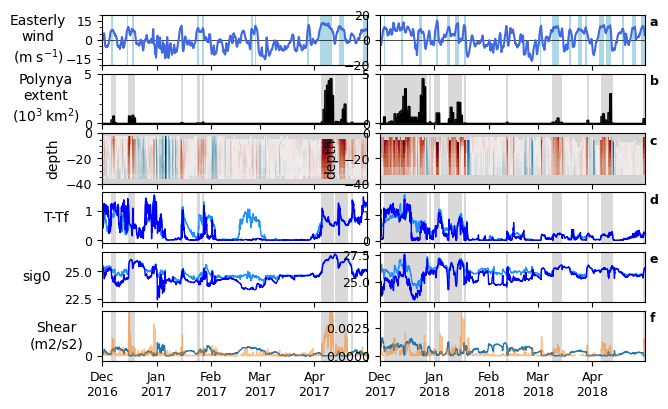

In [211]:
fig, axs = plt.subplots(6,2,figsize=(7,4.5), gridspec_kw={'height_ratios':[1,1,1,1,1,1,], })


for ax, year in zip(axs[0,:], [2017, 2018]):
    ax.set_ylim(-20,20)
    
    time_cond = (all_years==year)
    
    COND = (df.year==year)
    
#     ax.plot(pd.to_datetime(df['time'][COND].values), -df['u10'][COND])
    ax.plot(all_times[time_cond], -all_u10[time_cond],  alpha=1, lw=1.5, c='royalblue')
    
    
    COND = (dir_conds(df, 'wind')&speed_conds(df, 'wind'))&(df.year==year)
    for time in pd.to_datetime(df['time'][COND].values):
#         ax.axvline(time, lw=0.5, color='b', zorder=-1000)
        ax.axvspan(time, time+timedelta(hours=24), ymin=-20, ymax=20, lw=0, color='lightblue', zorder=-1)
    ax.axhline(0, c='k', lw=0.5, zorder=-1)

    

# polynya extent
#---------------
for ax, year in zip(axs[1,:], [2017, 2018]):    
    time_cond = (all_years==year)
    ax.set_ylim(-0.1,5)
    ax.fill_between(all_times[time_cond], all_extents[time_cond]/1000,0, lw=0, color='k')
    ax.plot(all_times[time_cond], all_extents[time_cond]/1000, color='k', lw=1)

    
# for ax, year in zip(axs[3,:], [2017, 2018]):
#     time_cond = (all_years==year)
    
#     ax.axhline(0, c='k',lw=0.5,  zorder=-2)
# #     ax.plot(all_times[time_cond], all_IHT[time_cond].magnitude/1e8, zorder=0, c='r', alpha=0.5)
# #     ax.step(all_times[time_cond][::24], daily_mean_IHC[time_cond[::24]].magnitude/1e8, where='post', zorder=1, color='r', lw=1.5)
# #     ax.fill_between(all_times[time_cond][::24], 0, daily_mean_IHC[time_cond[::24]].magnitude/1e8, step='post', alpha=0.25, color='r')

#     ax.plot(all_times[time_cond], all_IHC[time_cond].magnitude/1e8, zorder=1, color='mediumpurple', lw=1)
#     ax.fill_between(all_times[time_cond], 0, all_IHC[time_cond].magnitude/1e8, alpha=0.25, color='mediumpurple')
    
#     ax.plot(all_times[time_cond], all_IHC_sfc[time_cond].magnitude/1e8, zorder=1, color='r', lw=1)
#     ax.fill_between(all_times[time_cond], 0, all_IHC_sfc[time_cond].magnitude/1e8, alpha=0.25, color='r')
    
#     ax.set_ylim(-0.05,3)
    
    
        
            
for JJ in [1,3,4,5]:
    for ax, year in zip(axs[JJ,:], [2017, 2018]):    
        for time in all_times[(all_extents>0)&(all_years==year)][::24]:
#             ax.axvline(time, lw=0.5, color=[0.9,0.9,0.9], zorder=-1000)
            ax.axvspan(time, time+timedelta(hours=24), ymin=-20, ymax=20, lw=0, color=[0.85]*3, zorder=-1)



for ax, year, dst in zip(axs[2,:], [2017, 2018], [ds, ds2]):
    ax.patch.set_facecolor('lightgray')
    
    DST_interp = dst.interpolate_na(dim='depth', method='linear', max_gap=20)
    DST_interp = DST_interp.interpolate_na(dim='time', method='linear', max_gap='24H')
    DST_interp.se.plot(ax=ax, vmin=-1.5, vmax=1.5, cmap=cmocean.cm.balance, add_colorbar=False)
    ax.set_ylim(-40,0)

    
    
# for ax in axs[4:].ravel():
#     ax.set_ylim(-40,0)
#     ax.patch.set_facecolor('lightgray')
# for ax in axs[4:, 1]:
#     ax.set_ylim(-40,-15)
#     ax.patch.set_facecolor('lightgray')
    
ax = axs[3][0]
ax.plot(ds6.time, (ds6.Ct-ds6.Tf).mean('depth'), c='dodgerblue')
ax.plot(ds6.time, (ds6.Ct-ds6.Tf).sel(depth=-16), c='b')
# plt.legend()

ax = axs[3][1]

mesh = ax.plot(dss.time, (dss.Ct-dss.Tf).mean('depth'), c='dodgerblue')
ax.plot(dss.time, (dss.Ct-dss.Tf).sel(depth=-16), c='b')


ax = axs[4][0]
ax.plot(ds6.time, (ds6.sig0).mean('depth'), c='dodgerblue')
ax.plot(ds6.time, (ds6.sig0).sel(depth=-16), c='b')
# plt.legend()

ax = axs[4][1]

mesh = ax.plot(dss.time, (dss.sig0).mean('depth'), c='dodgerblue')
ax.plot(dss.time, (dss.sig0).sel(depth=-16), c='b')

    
# for ax in axs[:,1]:
#     ax.set_yticklabels([])
    
# for ax in axs[-2:,0]:
#     ax.set_yticklabels([])

# ax = axs[5][0]

# z_vals = [-17.3,-5.3]
# du = ds6.u.sel(depth=z_vals).diff('depth')
# dv = ds6.v.sel(depth=z_vals).diff('depth')
# dz = ds6.sel(depth=z_vals).depth.diff('depth').squeeze()
# bulkshear = (np.sqrt(du**2+dv**2)/dz).squeeze()
# ax.plot(ds6.time, bulkshear)


ax = axs[5][0]
ax.set_ylim(-0.0005,0.004)



z_vals = [-39,-16]
dp = ds6.sig0.sel(depth=z_vals).diff('depth')
dz = ds6.sel(depth=z_vals).depth.diff('depth').squeeze()
N2 = ((-9.8/1000)*(dp/dz)).squeeze()
ax.plot(ds6.time, N2)


time_range = slice(datetime(2016,12,1), datetime(2017,4,30,23))
open_years = '2016_2017'
time_cond = df.year==2017
mooring='M1'
dso = xr.open_dataset(f"/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/{mooring}/{mooring}_hourly_ocean_currents_{open_years}.nc")
z_vals = [-17.3,-5.3]
du = dso.u.sel(depth=z_vals).diff('depth')
dv = dso.v.sel(depth=z_vals).diff('depth')
dz = dso.sel(depth=z_vals).depth.diff('depth').squeeze()
bulkshear = (np.sqrt(du**2+dv**2)/dz).squeeze()
ax.plot(dso.time, bulkshear**2, alpha=0.5)



ax = axs[5][1]
ax.set_ylim(-0.0005,0.004)

z_vals = [-36,-16]
dp = dss.sig0.sel(depth=z_vals).diff('depth')
dz = dss.sel(depth=z_vals).depth.diff('depth').squeeze()
N2 = ((-9.8/1000)*(dp/dz)).squeeze()
ax.plot(dss.time, N2)



time_range = slice(datetime(2017,12,1), datetime(2018,4,30,23))
open_years = '2017_2018'
time_cond = df.year==2018
mooring='M1'
dso = xr.open_dataset(f"/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/{mooring}/{mooring}_hourly_ocean_currents_{open_years}.nc")
z_vals = [-18,-6]
du = dso.u.sel(depth=z_vals).diff('depth')
dv = dso.v.sel(depth=z_vals).diff('depth')
dz = dso.sel(depth=z_vals).depth.diff('depth').squeeze()
bulkshear = (np.sqrt(du**2+dv**2)/dz).squeeze()
ax.plot(dso.time, bulkshear**2, alpha=0.5)



# time_range = slice(datetime(2017,12,1), datetime(2018,4,30,23))
# open_years = '2017_2018'
# time_cond = df.year==2018



plt.subplots_adjust(wspace = 0.05, hspace=0.175)


        
for ax in axs[:,0]:
    year = 2017
    ax.set_xlim(datetime(year-1,12,1), datetime(year,4,30,23))
for ax in axs[:,1]:
    year = 2018
    ax.set_xlim(datetime(year-1,12,1), datetime(year,4,30,23))

for ax in axs.ravel():
    locator = mdates.MonthLocator() # Create a MonthLocator object
    ax.xaxis.set_major_locator(locator) # Set the major locator to monthly
    formatter = mdates.DateFormatter('%b\n%Y') # Define the format (e.g., YYYY-MM)
    ax.xaxis.set_major_formatter(formatter) # Apply the formatter
    
for ax in axs.ravel()[:-2]:
    ax.set_xticklabels([])
    
for aa, ax in enumerate(axs[:,1]):
    ax.text(1.02, 0.975, f'{chr(97+aa)}', weight='bold', ha='left', va='top',  transform=ax.transAxes, clip_on=False)    
    
    
N=0
axs[N,0].set_ylabel('Easterly\nwind\n$\mathrm{(m\;{s}^{-1})}$', rotation=0, labelpad=20, va='center')
axs[N,0].yaxis.set_major_locator(MultipleLocator(15))
axs[N,0].yaxis.set_minor_locator(MultipleLocator(5))

N = 1
axs[N,0].set_ylabel('Polynya\nextent\n$\mathrm{(10^{3}\;{km}^{2})}$', rotation=0, labelpad=28, va='center')  
axs[N,0].yaxis.set_major_locator(MultipleLocator(5))
axs[N,0].yaxis.set_minor_locator(MultipleLocator(1))

N = 2
# axs[N,0].set_ylabel('Shelf\ncurrent\n$\mathrm{(m\;{s}^{-1})}$', rotation=0, labelpad=23, va='center') 
axs[N,0].yaxis.set_major_locator(MultipleLocator(20))
axs[N,0].yaxis.set_minor_locator(MultipleLocator(5))





N = 3
axs[N,0].set_ylabel('T-Tf', rotation=0, labelpad=20, va='center')
# axs[N,0].set_ylabel('Heat\ncontent\n$\mathrm{(10^{8}\;J\;{m}^{-2})}$', rotation=0, labelpad=30, va='center')  
# axs[N,0].text(0.7, 0.75, 'Total', ha='center', c='mediumpurple', transform=axs[3,0].transAxes)
# axs[N,0].text(0.7, 0.5, 'Surface',ha='center',  c='r', transform=axs[3,0].transAxes)
# axs[N,0].yaxis.set_major_locator(MultipleLocator(3))
# axs[N,0].yaxis.set_minor_locator(MultipleLocator(0.5))

N = 4
axs[N,0].set_ylabel('sig0', rotation=0, labelpad=20, va='center')
# axs[N,0].set_ylabel('Depth\n(m)', rotation=0, labelpad=20, va='center')
# axs[N,0].yaxis.set_major_locator(MultipleLocator(20))
# axs[N,0].yaxis.set_minor_locator(MultipleLocator(5))

# N = 5
# axs[N,0].set_ylabel('Depth\n(m)', rotation=0, labelpad=20, va='center')
# axs[N,0].yaxis.set_major_locator(MultipleLocator(20))
# axs[N,0].yaxis.set_minor_locator(MultipleLocator(5))


N = 5
axs[N,0].set_ylabel('Shear\n(m2/s2)', rotation=0, labelpad=20, va='center')
axs[N,0].yaxis.set_major_locator(MultipleLocator(20))
axs[N,0].yaxis.set_minor_locator(MultipleLocator(5))

In [195]:
dst

<xarray.Dataset>
Dimensions:  (depth: 16, time: 8761)
Coordinates:
  * depth    (depth) float64 -35.3 -33.3 -31.3 -29.3 ... -9.3 -7.3 -5.3 -3.3
  * time     (time) datetime64[ns] 2016-10-01 2016-10-01T01:00:00 ... 2017-10-01
Data variables:
    u        (depth, time) float64 nan nan nan nan nan ... nan nan nan nan nan
    v        (depth, time) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    lat:      69.7706
    lon:      -139.2548

In [193]:
ds

<xarray.Dataset>
Dimensions:  (depth: 16, time: 8761)
Coordinates:
  * depth    (depth) float64 -35.3 -33.3 -31.3 -29.3 ... -9.3 -7.3 -5.3 -3.3
  * time     (time) datetime64[ns] 2016-10-01 2016-10-01T01:00:00 ... 2017-10-01
Data variables:
    u        (depth, time) float64 ...
    v        (depth, time) float64 ...
Attributes:
    lat:      69.7706
    lon:      -139.2548

In [203]:
dso.depth

<xarray.DataArray 'depth' (depth: 10)>
array([-30., -24., -22., -18., -14., -12., -10.,  -8.,  -6.,  -4.])
Coordinates:
  * depth    (depth) float64 -30.0 -24.0 -22.0 -18.0 ... -10.0 -8.0 -6.0 -4.0

In [100]:
ds2.interpolate_na(dim='time', method='linear', max_gap='6H')


<xarray.Dataset>
Dimensions:  (depth: 10, time: 3624)
Coordinates:
  * depth    (depth) float64 -30.0 -24.0 -22.0 -18.0 ... -10.0 -8.0 -6.0 -4.0
  * time     (time) datetime64[ns] 2017-12-01 ... 2018-04-30T23:00:00
Data variables:
    u        (depth, time) float64 -0.4222 -0.4119 -0.4137 ... -0.5501 -0.4883
    v        (depth, time) float64 0.1624 0.1652 0.1773 ... 0.5777 0.5748 0.5873
    se       (depth, time) float64 0.439 0.4322 0.4406 ... 0.8077 0.7803 0.7368
Attributes:
    lat:      69.7718
    lon:      -139.2582

In [ ]:
all_times

In [11]:
all_dma_se

array([-0.08147418, -0.08402676, -0.09315489, ...,  0.69558163,
        0.68847814,  0.68270033])

In [564]:
all_IHC

Magnitude,[105103139.73903504 105737291.20449054 106272795.53693506 ... 49494143.337870054 49331439.259941414 48828890.94262738]
Units,joule/meter2


In [ ]:
# # for ax, year in zip(axs[1,:], [2017, 2018]):    
# #     time_cond = (all_years==year)
# #     ax.set_ylim(-2000,2000)
# #     ax.plot(all_times[time_cond], all_IHT[time_cond].magnitude/10e4, color='r', lw=1)
    
    
# # for ax, year in zip(axs[2,:], [2017, 2018]):  
    
# #     ax.axhline(0, c='k', lw=0.5, zorder=-1)
# #     ax.set_ylim(-20,20)
    
# #     time_cond = (all_years==year)
    
# #     ax.plot(all_times[time_cond], 
# #             -all_u10[time_cond], c='gray', alpha=1, lw=1.5)
    
# #     COND = (dir_conds(df, 'wind')&speed_conds(df, 'wind'))&(df.year==year)
# #     ax.scatter(df['time'][COND], df['s10'][COND])


In [516]:
axs[4:].ravel()

array([<Axes: >, <Axes: >, <Axes: ylabel='Depth (m)'>, <Axes: >,
       <Axes: ylabel='Depth (m)'>, <Axes: >], dtype=object)

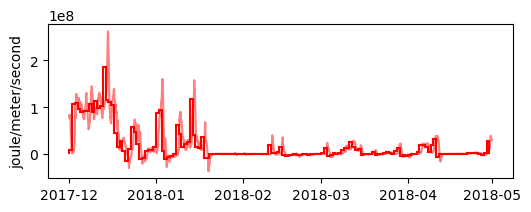

In [517]:
fig, ax = plt.subplots(figsize=(6,2))
plt.plot(all_times[time_cond], all_IHT[time_cond], zorder=0, c='r', alpha=0.5)
plt.stairs(all_daily_IHT[time_cond[::24]][1:], edges = all_times[time_cond][::24], zorder=1, color='r', lw=1.5)

(-1.0, 3.0)

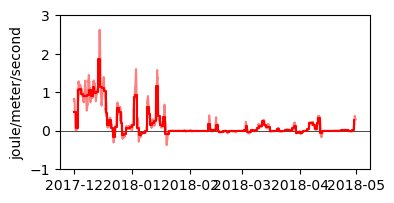

In [506]:
fig, ax = plt.subplots(figsize=(4,2))
ax.axhline(0, c='k',lw=0.5,  zorder=-2)
plt.plot(all_times[time_cond], all_IHT[time_cond]/1e8, zorder=0, c='r', alpha=0.5)
plt.step(all_times[time_cond][::24], all_daily_IHT[time_cond[::24]]/1e8, where='post', zorder=1, color='r', lw=1.5)
ax.set_ylim(-1,3)
# plt.step(all_times[time_cond][::24], all_daily_IHT[time_cond[::24]][:], zorder=1, color='r', lw=1.5, where='post')

In [507]:
len(all_daily_IHT)

302

In [508]:
(convert / units('day')).to('W/m2')

<Quantity(3.54488426e+08, 'watt / meter ** 2')>

In [509]:
np.nanpercentile(all_sfc_T[all_extents>0], 75)

0.9069975043996434

In [510]:
np.nanpercentile(all_sfc_T[all_extents==0], 50)

0.04676212937760016

In [129]:
np.nanpercentile(all_sfc_T[all_extents==0], 75)

0.21210273338494523

In [ ]:
'width_ratios':[]

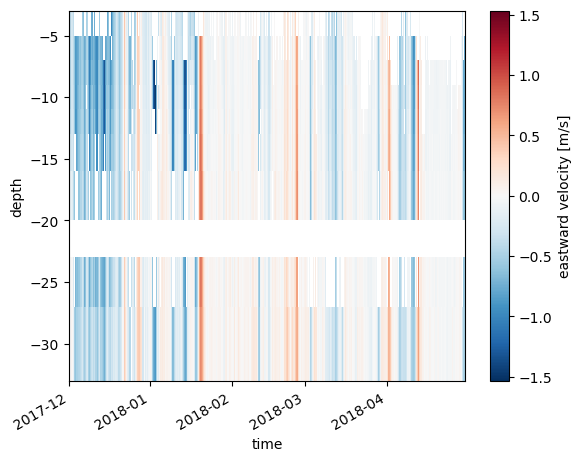

In [580]:
dso = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/M1_hourly_ocean_currents_2017_2018.nc')
dso = dso.sel(time = time_ranges[1])
dso.u.plot()


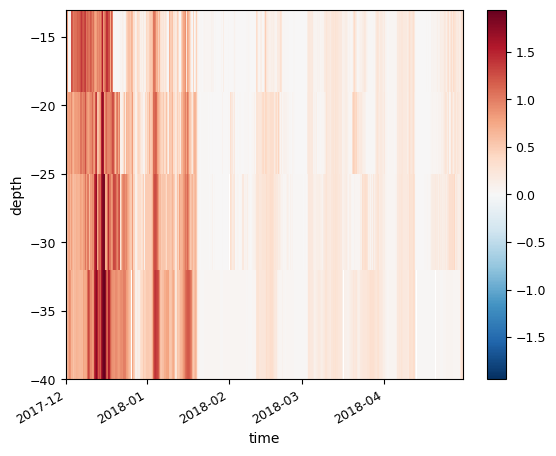

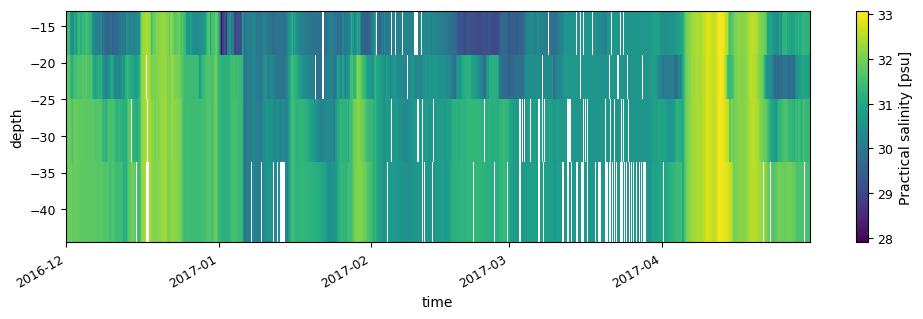

In [157]:
dss = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/M1_hourly_tempsalinity_2017_2018.nc')
dss = dss.sel(time = time_ranges[1])
(dss.Ct-dss.Tf).plot()

fig, ax = plt.subplots(figsize=(12,3))
ds6 = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/mooring_data/MARES_moorings/M1/M1_hourly_tempsalinity_2016_2017.nc')
ds6 = ds6.sel(time = time_ranges[0])
# (ds6.Ct-ds6.Tf).plot()
(ds6.Sp).plot()


In [61]:
df['time'][COND], df['s10'][COND]

(Series([], Name: time, dtype: object), Series([], Name: s10, dtype: float64))

<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:38: SyntaxWarning: invalid escape sequence '\m'
<>:39: SyntaxWarning: invalid escape sequence '\m'
<>:61: SyntaxWarning: invalid escape sequence '\m'
<>:62: SyntaxWarning: invalid escape sequence '\m'
<>:18: SyntaxWarning: invalid escape sequence '\m'
<>:38: SyntaxWarning: invalid escape sequence '\m'
<>:39: SyntaxWarning: invalid escape sequence '\m'
<>:61: SyntaxWarning: invalid escape sequence '\m'
<>:62: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_48184/3741301750.py:18: SyntaxWarning: invalid escape sequence '\m'
  ax.text(0.95,0.95, '$\mathrm{Polynya\;extent \;({km}^{2})}$', c='k', ha='right', va='top', transform=ax.transAxes)
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_48184/3741301750.py:38: SyntaxWarning: invalid escape sequence '\m'
  ax.text(0.95,0.95, '$\mathrm{Easterly\;wind \;(m\;{s}^{-1})}$', c='gray', ha='right', va='top', transform=ax.transAxe

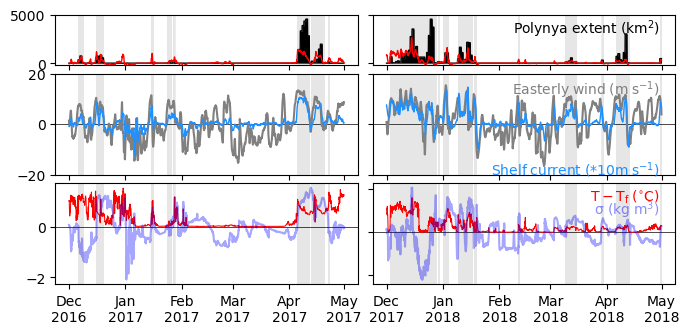

In [511]:
fig, axs = plt.subplots(3,2,figsize=(8,3.5), gridspec_kw={'height_ratios':[1,2,2]})


    
for ax, year in zip(axs[0,:], [2017, 2018]):    
    
    time_cond = (all_years==year)
    
    ax.set_ylim(-200,5000)
    ax.fill_between(all_times[time_cond], all_extents[time_cond],0, lw=0, color='k')
    ax.plot(all_times[time_cond], all_extents[time_cond], color='k', lw=1)
    ax.plot(all_times[time_cond], all_IHT[time_cond].magnitude/10e4, color='r', lw=1)
    
    
    for time in all_times[(all_extents>0)&(all_years==year)]:
        ax.axvline(time, lw=0.5, color=[0.9,0.9,0.9], zorder=-1000)
        
ax.text(0.95,0.95, '$\mathrm{Polynya\;extent \;({km}^{2})}$', c='k', ha='right', va='top', transform=ax.transAxes)

for ax, year in zip(axs[1,:], [2017, 2018]):
    ax.axhline(0, c='k', lw=0.5, zorder=-1)
    ax.set_ylim(-20,20)
    
    time_cond = (all_years==year)
    
    ax.plot(all_times[time_cond], 
            -all_u10[time_cond], c='gray', alpha=1, lw=1.5)
    
#     ax.plot(all_times[time_cond], 
#             all_v10[time_cond], c='k', alpha=1, lw=0.5)
    ax.plot(all_times[time_cond], 
            10*all_dma_se[time_cond], c='dodgerblue', lw=1)
    
    for time in all_times[(all_extents>0)&(all_years==year)]:
        ax.axvline(time, lw=0.5, color=[0.9,0.9,0.9], zorder=-1000)
        
        
ax.text(0.95,0.95, '$\mathrm{Easterly\;wind \;(m\;{s}^{-1})}$', c='gray', ha='right', va='top', transform=ax.transAxes)
ax.text(0.95,0.15, '$\mathrm{Shelf\;current \;(*10 m\;{s}^{-1})}$', c='dodgerblue', ha='right', va='top', transform=ax.transAxes)
        
    
for ax, year in zip(axs[2,:], [2017, 2018]):
    ax.axhline(0, c='k', lw=0.5, zorder=-1)
#     ax.set_ylim(-1.9,1.9)
    ax.plot(all_times[all_years==year], all_sfc_T[all_years==year], c='r', lw=0.75)    
#     ax.plot(all_times[all_years==year], 
#             (all_dma_sig-26)[all_years==year], c='b', alpha=0.35)
    
    ax.plot(all_times[all_years==year], 
            (all_sfc_sig-all_lp_sfc_sig)[all_years==year], c='b', alpha=0.35)
    
#     all_lp_dma_sig
    
#     ax.plot(all_times[all_years==year], 
#             (all_dma_sig-all_lp_dma_sig)[all_years==year], c='k', alpha=0.35)
    
    for time in all_times[(all_extents>0)&(all_years==year)]:
        ax.axvline(time, lw=0.5, color=[0.9,0.9,0.9], zorder=-1000)
        
        
ax.text(0.95,0.95, '$\mathrm{T - T_{f} \;(^{\circ}C)}$', c='r', ha='right', va='top', transform=ax.transAxes)
ax.text(0.95,0.85, '$\mathrm{\sigma}$ ($\mathrm{kg\;{m}^3}$)', c='b', alpha=0.45, ha='right', va='top', transform=ax.transAxes)

for ax in axs[:,1]:
    ax.set_yticklabels([])
    
plt.subplots_adjust(wspace = 0.05, hspace=0.1)

for ax in axs.ravel():
    locator = mdates.MonthLocator() # Create a MonthLocator object
    ax.xaxis.set_major_locator(locator) # Set the major locator to monthly
    formatter = mdates.DateFormatter('%b\n%Y') # Define the format (e.g., YYYY-MM)
    ax.xaxis.set_major_formatter(formatter) # Apply the formatter
    
for ax in axs.ravel()[:-2]:
    ax.set_xticklabels([])
    
    


# fig.savefig('../figures/results/case_study_overview.png', dpi=400, bbox_inches='tight', pad_inches=0)

In [25]:
len(all_IHT)

8736

In [26]:
len(all_length_145s)

8736

In [496]:
daily_mean_IHT/1e8

<Quantity([-1.44371396e-02  2.10582293e-01  9.80317860e-03  3.81111240e-02
 -1.03573099e-02  2.50650513e-01  5.27105068e-01  1.95356502e-01
 -2.99655249e-02 -1.11126187e-01  1.32536207e-02  2.26698624e-01
 -5.68013180e-02 -3.18115311e-03  2.43317617e-01  7.45581055e-01
  6.85551797e-02  4.81604811e-01  2.80621683e-01  2.34120035e-02
 -7.50558237e-02 -1.16855360e-01 -8.35434755e-02 -1.94510399e-01
 -1.58951002e-01 -8.12165129e-02  1.09530226e-01  1.46299487e-01
  1.29489389e-01  6.89365534e-01 -1.41218987e-01 -2.31218389e-01
 -8.52903059e-02 -1.56557232e-01 -9.34785329e-02 -1.19706950e-01
 -9.78821923e-02 -1.11465828e-03 -8.33132258e-03 -4.35412730e-03
 -7.30124561e-03 -1.01428135e-02 -9.65438831e-03 -5.36867729e-04
  1.50546891e-02  4.96879705e-01 -7.00214975e-02  5.49013821e-02
 -9.26131527e-05 -1.11064459e-02 -8.29787461e-03 -4.95968800e-03
 -1.18061920e-02 -8.32559366e-03  5.36061162e-02  2.11189870e-01
  2.45595134e-01  3.09947558e-01  2.63076492e-01  5.31663790e-02
 -5.96683017e-02 -3.93718586e-02 -2.71779888e-01 -2.14178618e-01
 -1.32597111e-01 -9.61149293e-03  1.60360701e-03  1.77014644e-03
  1.01282109e-03 -2.61701907e-03 -4.19578483e-03 -1.62648486e-03
 -1.08684102e-03  4.73163780e-03 -5.88306698e-04  2.77656803e-04
 -1.49836727e-03  6.87123561e-03  2.97100559e-02  3.61023740e-02
  7.30508069e-02  1.11470893e-01  2.82903171e-02 -2.57944069e-02
 -4.28656141e-02  9.49831453e-02  6.72008502e-02  4.63110615e-02
  1.31670275e-01 -1.13336635e-01 -7.68785463e-02 -1.37697537e-02
 -2.10602882e-02 -1.02126618e-02 -1.48145489e-04 -9.93209260e-04
  6.42811847e-05 -8.60412332e-06  3.02645925e-03 -2.75870152e-03
 -8.75571494e-04 -2.00645421e-03 -7.09594537e-05 -6.69927241e-04
 -1.00798354e-03 -1.88257748e-04  4.99585978e-04  2.36620202e-04
  1.20591564e-04  5.73901815e-04  5.59178197e-04  6.22250854e-04
  1.08041817e-03  6.72960481e-04 -3.45328795e-04 -1.21855307e-03
 -5.02335948e-04  1.46917652e-03  6.14624450e-03  4.82561454e-03
  1.21037052e-02  7.37640839e-03  1.96810841e-02  3.09466245e-02
  6.12142214e-02  9.52747740e-01  1.28562936e+00  1.12341676e+00
  1.00012356e+00  9.92131207e-01  6.26768648e-01  3.32966752e-01
 -7.34066603e-02 -3.63024016e-02  2.71935766e-01  7.67019198e-01
  7.26914272e-01  7.13504536e-01  5.77431339e-01  8.33048780e-02
  4.81881851e-02  4.69860060e-02  3.56189299e-01  3.14536118e-01
  9.47806462e-02  4.06654080e-02  4.97010808e-02  1.02609877e-01
  4.10280715e-01  3.12823055e-01  1.95218333e-01  4.96997306e-01
  7.30604558e-02  1.05922141e+00  1.08674761e+00  9.67262170e-01
  8.98714984e-01  9.10705363e-01  9.26000492e-01  1.06502614e+00
  9.03777776e-01  1.14078186e+00  9.87028307e-01  1.01765682e+00
  1.86679005e+00  1.14426462e+00  1.10783892e+00  1.04064213e+00
  4.50065563e-01  1.37926033e-01  2.83995073e-01  6.56008578e-02
 -1.49175335e-01  1.08528364e-01  5.84904895e-01  4.75511877e-01
  2.13651621e-01 -1.02866335e-01 -9.22789464e-02  6.92047565e-02
  7.50287701e-02  8.60701363e-02  1.53603450e-01  8.72141352e-01
  9.40036789e-01  6.73526897e-02 -1.00773340e-01 -7.03304270e-02
 -5.19031378e-02 -1.22157890e-02  6.18050426e-01  4.34663107e-01
  1.56826984e-01  2.00489281e-01  2.63338573e-01  1.16908989e+00
  3.95906649e-01  1.49472448e-01  1.30542587e-01  3.64873029e-01
 -8.48657207e-02 -8.29058697e-02 -6.51805253e-03  8.14493644e-04
  7.31356638e-04 -1.10910646e-03 -3.15122311e-04  9.67701754e-05
 -2.20650163e-03 -1.47333486e-04 -3.33086664e-06 -2.53525150e-03
 -2.36767214e-03  5.02231015e-03 -4.70794814e-03 -5.24051554e-03
 -1.89735447e-03 -1.48038263e-03 -5.98060830e-03 -3.15231487e-03
 -3.47746783e-03 -4.70652431e-03 -7.84252345e-03  1.83703386e-01
  1.30584728e-02  8.03097614e-03  2.97270947e-02  1.53063434e-01
 -1.68328603e-02 -3.78354933e-02 -2.16126671e-02 -1.64934524e-02
 -8.07267420e-04 -3.23671064e-02 -1.62096347e-02 -5.78601488e-03
 -8.99827678e-03 -1.70758474e-02 -7.04273219e-03 -4.42575568e-04
 -1.53919950e-03 -1.76363679e-03  1.09026454e-02  1.22016914e-01
 -4.35551309e-02 -2.12810

In [33]:
# daily_mean_IHT = np.array([])
# for ii in np.arange(0, len(all_IHT), 24):
#     daily_mean_IHT = np.append(daily_mean_IHT, np.nansum(all_IHT.to('J/m/hour')[ii:ii+24]*units('hour')))
    
    
daily_mean_u10 = np.array([])
for ii in np.arange(0, len(all_u10), 24):
    daily_mean_u10 = np.append(daily_mean_u10, np.nanmean(all_u10[ii:ii+24]))
    

    
daily_mean_IHT = np.array([])
for ii in np.arange(0, len(all_IHT), 24):
    daily_mean_IHT = np.append(daily_mean_IHT, np.nanmean(all_IHT.to('J/m/s')[ii:ii+24]))
    
    
daily_mean_IHC = np.array([])
for ii in np.arange(0, len(all_IHC), 24):
    daily_mean_IHC = np.append(daily_mean_IHC, np.nanmean(all_IHC.to('J/m2')[ii:ii+24]))
    
    
daily_mean_current = np.array([])
for ii in np.arange(0, len(all_dma_se), 24):
    daily_mean_current = np.append(daily_mean_current, np.nansum(all_dma_se[ii-0:ii+24]*units('m/s').to('km/hour')*units('hour')))
    
daily_mean_sfc_t = np.array([])
for ii in np.arange(0, len(all_sfc_T), 24):
    daily_mean_sfc_t = np.append(daily_mean_sfc_t, np.nanmean(all_sfc_T[ii-0:ii+24]))

daily_mean_u10 = np.array([])
for ii in np.arange(0, len(all_u10), 24):
    daily_mean_u10 = np.append(daily_mean_u10, np.nanmean(all_u10[ii-0:ii+24]))

all_u10

array([-1.36343062, -1.00738227, -0.76599014, ..., -5.62870741,
       -4.56007338, -3.82553005])

In [98]:
# all_widths = np.array([])
# all_daily_lengths = np.array([])
# all_daily_IHT = np.array([])
# all_years = np.array([])
# all_times = np.array([], dtype=np.datetime64)
# all_sfc_T = np.array([])
# all_sfc_sal = np.array([])
# all_dma_sig = np.array([])
# all_bot_sig = np.array([])
# all_sfc_sig = np.array([])
# all_lp_dma_sig = np.array([])
# all_lp_sfc_sig = np.array([])
# all_lp_bot_sig = np.array([])

# all_dma_T = np.array([])
# all_dma_se = np.array([])
# all_ice_se = np.array([])
# all_IHT = np.array([])
# all_IHC = np.array([])
# all_IHT_sfc = np.array([])
# all_IHC_sfc = np.array([])
# all_months = np.array([])
# all_doy = np.array([])
# all_u10 = np.array([])
# all_v10 = np.array([])

# all_ui = np.array([])
# all_vi = np.array([])

# all_uo = np.array([])
# all_vo = np.array([])

(-1.0, 1.5)

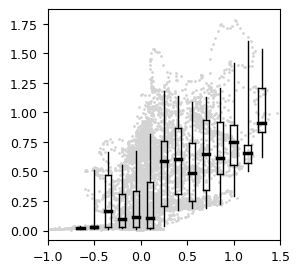

In [154]:
fig, ax = plt.subplots(figsize=(3,3))


lag = 20
ax.scatter(all_dma_se[:-lag], (all_dma_T)[lag:], s=1, c='lightgray')


# ax.scatter(all_dma_se[:-lag], all_IHT[lag:], s=1, c='lightgray')

# ax.scatter(cbin_centers, vals[50], c='k')


for cc in range(len(cbin_centers)):
    
    ww = 0.035
    ax.plot([cbin_centers[cc]-ww]*2, [vals[25][cc], vals[75][cc]], c='k', zorder=1)
    ax.plot([cbin_centers[cc]+ww]*2, [vals[25][cc], vals[75][cc]], c='k', zorder=1)
    ax.plot([cbin_centers[cc]+ww,cbin_centers[cc]-ww], [vals[25][cc]]*2, c='k', zorder=1)
    ax.plot([cbin_centers[cc]+ww,cbin_centers[cc]-ww], [vals[75][cc]]*2, c='k', zorder=1)
    ax.plot([cbin_centers[cc]+ww,cbin_centers[cc]-ww], [vals[50][cc]]*2, c='k', lw=2.5, zorder=1)
    
    # whiskr=ers
    ax.plot([cbin_centers[cc]]*2, [vals[5][cc],vals[25][cc]], c='k', zorder=1)
    ax.plot([cbin_centers[cc]]*2, [vals[75][cc],vals[95][cc]], c='k', zorder=1)

# ax.set_ylim(-1.5,1.5)
ax.set_xlim(-1,1.5)


In [152]:
cbin_edges = np.arange(-2,2.1,0.22)
cbin_width = np.diff(cbin_edges)[0]
cbin_centers = cbin_edges[:-1] + cbin_width

percents = [5,25,50,75,95]
vals = {}
for per in percents:
    vals[per] = np.array([])
    
# lag = 16
for bl, br in zip(cbin_edges[:-1], cbin_edges[1:]):
    
    within_bin = (all_dma_se[:-lag]>=bl) & (all_dma_se[:-lag]<br)
    
    if np.sum(within_bin)>24:
        vals_within = (all_dma_T)[lag:][within_bin]
    else:
        vals_within = [np.nan]
    for per in percents:
        vals[per] = np.append(vals[per], np.nanpercentile(vals_within, per))
    
        
    

In [62]:

    
    print(bl,br)

-2.0 -1.9
-1.9 -1.7999999999999998
-1.7999999999999998 -1.6999999999999997
-1.6999999999999997 -1.5999999999999996
-1.5999999999999996 -1.4999999999999996
-1.4999999999999996 -1.3999999999999995
-1.3999999999999995 -1.2999999999999994
-1.2999999999999994 -1.1999999999999993
-1.1999999999999993 -1.0999999999999992
-1.0999999999999992 -0.9999999999999991
-0.9999999999999991 -0.899999999999999
-0.899999999999999 -0.7999999999999989
-0.7999999999999989 -0.6999999999999988
-0.6999999999999988 -0.5999999999999988
-0.5999999999999988 -0.49999999999999867
-0.49999999999999867 -0.3999999999999986
-0.3999999999999986 -0.2999999999999985
-0.2999999999999985 -0.1999999999999984
-0.1999999999999984 -0.09999999999999831
-0.09999999999999831 1.7763568394002505e-15
1.7763568394002505e-15 0.10000000000000187
0.10000000000000187 0.20000000000000195
0.20000000000000195 0.30000000000000204
0.30000000000000204 0.40000000000000213
0.40000000000000213 0.5000000000000022
0.5000000000000022 0.6000000000000023


/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1562: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [52]:
help(plotter.quick_hist(vals, bin_edges=[]))

Help on module plot_simply.general in plot_simply:

NAME
    plot_simply.general - # Functions for plotting

CLASSES
    matplotlib.colors.Normalize(builtins.object)
        TwopointNormalize

    class TwopointNormalize(matplotlib.colors.Normalize)
     |  TwopointNormalize(vmin=None, vmax=None, vmid1=None, vmid2=None, clip=False)
     |
     |  Class for normalizing colormap based off two midpoints.
     |
     |  INPUT:
     |  - vmin: min value
     |  - vmid1: lower midpoint value
     |  - vmid2: higher midpoint value
     |  - vmax: max value
     |
     |  OUTPUT:
     |  - normalization scaling [vmin, vmid1, vmid2, vmax] to [0, 1/3, 2/3, 1] of colormap
     |
     |  Latest recorded update:
     |  12-17-2024
     |
     |  Method resolution order:
     |      TwopointNormalize
     |      matplotlib.colors.Normalize
     |      builtins.object
     |
     |  Methods defined here:
     |
     |  __call__(self, value, clip=None)
     |      Normalize *value* data in the ``[vmin

In [115]:
daily_mean_IHT

<Quantity([-1.44371396e+06  2.10582293e+07  9.80317860e+05  3.81111240e+06
 -1.03573099e+06  2.50650513e+07  5.27105068e+07  1.95356502e+07
 -2.99655249e+06 -1.11126187e+07  1.32536207e+06  2.26698624e+07
 -5.68013180e+06 -3.18115311e+05  2.43317617e+07  7.45581055e+07
  6.85551797e+06  4.81604811e+07  2.80621683e+07  2.34120035e+06
 -7.50558237e+06 -1.16855360e+07 -8.35434755e+06 -1.94510399e+07
 -1.58951002e+07 -8.12165129e+06  1.09530226e+07  1.46299487e+07
  1.29489389e+07  6.89365534e+07 -1.41218987e+07 -2.31218389e+07
 -8.52903059e+06 -1.56557232e+07 -9.34785329e+06 -1.19706950e+07
 -9.78821923e+06 -1.11465828e+05 -8.33132258e+05 -4.35412730e+05
 -7.30124561e+05 -1.01428135e+06 -9.65438831e+05 -5.36867729e+04
  1.50546891e+06  4.96879705e+07 -7.00214975e+06  5.49013821e+06
 -9.26131527e+03 -1.11064459e+06 -8.29787461e+05 -4.95968800e+05
 -1.18061920e+06 -8.32559366e+05  5.36061162e+06  2.11189870e+07
  2.45595134e+07  3.09947558e+07  2.63076492e+07  5.31663790e+06
 -5.96683017e+06 -3.93718586e+06 -2.71779888e+07 -2.14178618e+07
 -1.32597111e+07 -9.61149293e+05  1.60360701e+05  1.77014644e+05
  1.01282109e+05 -2.61701907e+05 -4.19578483e+05 -1.62648486e+05
 -1.08684102e+05  4.73163780e+05 -5.88306698e+04  2.77656803e+04
 -1.49836727e+05  6.87123561e+05  2.97100559e+06  3.61023740e+06
  7.30508069e+06  1.11470893e+07  2.82903171e+06 -2.57944069e+06
 -4.28656141e+06  9.49831453e+06  6.72008502e+06  4.63110615e+06
  1.31670275e+07 -1.13336635e+07 -7.68785463e+06 -1.37697537e+06
 -2.10602882e+06 -1.02126618e+06 -1.48145489e+04 -9.93209260e+04
  6.42811847e+03 -8.60412332e+02  3.02645925e+05 -2.75870152e+05
 -8.75571494e+04 -2.00645421e+05 -7.09594537e+03 -6.69927241e+04
 -1.00798354e+05 -1.88257748e+04  4.99585978e+04  2.36620202e+04
  1.20591564e+04  5.73901815e+04  5.59178197e+04  6.22250854e+04
  1.08041817e+05  6.72960481e+04 -3.45328795e+04 -1.21855307e+05
 -5.02335948e+04  1.46917652e+05  6.14624450e+05  4.82561454e+05
  1.21037052e+06  7.37640839e+05  1.96810841e+06  3.09466245e+06
  6.12142214e+06  9.52747740e+07  1.28562936e+08  1.12341676e+08
  1.00012356e+08  9.92131207e+07  6.26768648e+07  3.32966752e+07
 -7.34066603e+06 -3.63024016e+06  2.71935766e+07  7.67019198e+07
  7.26914272e+07  7.13504536e+07  5.77431339e+07  8.33048780e+06
  4.81881851e+06  4.69860060e+06  3.56189299e+07  3.14536118e+07
  9.47806462e+06  4.06654080e+06  4.97010808e+06  1.02609877e+07
  4.10280715e+07  3.12823055e+07  1.95218333e+07  4.96997306e+07
  7.30604558e+06  1.05922141e+08  1.08674761e+08  9.67262170e+07
  8.98714984e+07  9.10705363e+07  9.26000492e+07  1.06502614e+08
  9.03777776e+07  1.14078186e+08  9.87028307e+07  1.01765682e+08
  1.86679005e+08  1.14426462e+08  1.10783892e+08  1.04064213e+08
  4.50065563e+07  1.37926033e+07  2.83995073e+07  6.56008578e+06
 -1.49175335e+07  1.08528364e+07  5.84904895e+07  4.75511877e+07
  2.13651621e+07 -1.02866335e+07 -9.22789464e+06  6.92047565e+06
  7.50287701e+06  8.60701363e+06  1.53603450e+07  8.72141352e+07
  9.40036789e+07  6.73526897e+06 -1.00773340e+07 -7.03304270e+06
 -5.19031378e+06 -1.22157890e+06  6.18050426e+07  4.34663107e+07
  1.56826984e+07  2.00489281e+07  2.63338573e+07  1.16908989e+08
  3.95906649e+07  1.49472448e+07  1.30542587e+07  3.64873029e+07
 -8.48657207e+06 -8.29058697e+06 -6.51805253e+05  8.14493644e+04
  7.31356638e+04 -1.10910646e+05 -3.15122311e+04  9.67701754e+03
 -2.20650163e+05 -1.47333486e+04 -3.33086664e+02 -2.53525150e+05
 -2.36767214e+05  5.02231015e+05 -4.70794814e+05 -5.24051554e+05
 -1.89735447e+05 -1.48038263e+05 -5.98060830e+05 -3.15231487e+05
 -3.47746783e+05 -4.70652431e+05 -7.84252345e+05  1.83703386e+07
  1.30584728e+06  8.03097614e+05  2.97270947e+06  1.53063434e+07
 -1.68328603e+06 -3.78354933e+06 -2.16126671e+06 -1.64934524e+06
 -8.07267420e+04 -3.23671064e+06 -1.62096347e+06 -5.78601488e+05
 -8.99827678e+05 -1.70758474e+06 -7.04273219e+05 -4.42575568e+04
 -1.53919950e+05 -1.76363679e+05  1.09026454e+06  1.22016914e+07
 -4.35551309e+06 -2.12810

In [51]:
cum_pack_drifts = np.array([])

open_dates = pd.to_datetime(all_times[all_extents>0][::24])
df_times = pd.to_datetime(df.time.values)


for ii in range(len(open_dates)):
    curr_date = open_dates[ii]
    
    seq = df[df_times==curr_date].sequence.values[0]
    ed = df[df_times==curr_date].event_day.values[0]
    
    day_before_ind = df[(df.sequence==seq)&(df.event_day==1)].index.values[0] -1
    day_during_ind = df[(df.sequence==seq)&(df.event_day==ed)].index.values[0]

#     up_to_day_during = (df.sequence==seq)&(df.event_day<=ed)

#     total_pack = - np.cumsum(0.04 * df[day_before_ind:day_during_ind].u10.values * units('m/s').to('km/day'))[-1]

    total_pack = - np.cumsum(df[day_before_ind:day_during_ind].ui.values * units('cm/s').to('km/day'))[-1]

    cum_pack_drifts = np.append(cum_pack_drifts, total_pack.magnitude)

IndexError: index 0 is out of bounds for axis 0 with size 0

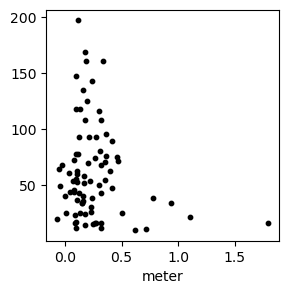

In [16]:
fig, ax= plt.subplots(figsize=(3,3))

# ax.scatter(cum_pack_drifts, all_extents[all_extents>0][::24]/50)

# ax.scatter((daily_mean_IHT[all_extents[::24]>0]/convert).to('cm'), 
#            all_extents[all_extents>0][::24], s=10, c='k', alpha=1)

# ax.scatter((daily_mean_IHT/convert).to('cm'), all_length_145s[::24], s=10, c='k', alpha=1)

# ax.scatter(daily_mean_IHT/10e12, 
#            all_length_145s[::24], s=10, c='k', alpha=1)


L = 50 * units('km').to('m')
L = all_length_145s[::24]* units('km').to('m')
ax.scatter(daily_mean_IHT/(L*cst['L_i']*cst['rho_i']), 
           all_length_145s[::24], s=10, c='k', alpha=1)



# /(cst['rho_i'] * cst['L_i'])
# ax.scatter(((daily_mean_IHT/(cst['rho_i'] * cst['L_i']))/(all_length_145s[::24]*units('km'))).to('cm'), all_length_145s[::24], s=10, c='k', alpha=1)


In [374]:
final_days

NameError: name 'final_days' is not defined

In [93]:
AW_events = (all_times[::24] > datetime(2017,12,5)) & (all_times[::24] < datetime(2018,2,1))

# AW_events = (all_years[::24]==2018) & (AW_events==False)

In [94]:
print(all_times[::24][nonAW_events]);
print(all_times[::24][yesAW_events]);

DatetimeIndex(['2017-12-03', '2017-12-04', '2017-12-05', '2018-02-11',
               '2018-03-09', '2018-03-10', '2018-03-11', '2018-03-12',
               '2018-03-13', '2018-03-14', '2018-03-29', '2018-04-06',
               '2018-04-07', '2018-04-08', '2018-04-09', '2018-04-10',
               '2018-04-11', '2018-04-12', '2018-04-30'],
              dtype='datetime64[ns]', freq=None)
DatetimeIndex(['2017-12-06', '2017-12-07', '2017-12-08', '2017-12-09',
               '2017-12-10', '2017-12-11', '2017-12-12', '2017-12-13',
               '2017-12-14', '2017-12-15', '2017-12-16', '2017-12-17',
               '2017-12-18', '2017-12-19', '2017-12-20', '2017-12-21',
               '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25',
               '2017-12-26', '2017-12-27', '2017-12-29', '2018-01-01',
               '2018-01-02', '2018-01-03', '2018-01-09', '2018-01-10',
               '2018-01-11', '2018-01-12', '2018-01-13', '2018-01-14',
               '2018-01-15', '2018-01-16'

In [95]:
nonAW_events = ((AW_events==False)&(all_extents[::24]>0))&(all_years[::24]==2018)
yesAW_events = (AW_events)&(all_extents[::24]>0)

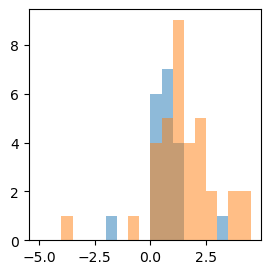

In [96]:
fig, ax = plt.subplots(figsize=(3,3))
# plt.hist(all_length_145s[::24][nonAW_events], alpha=0.5);
# plt.hist(all_length_145s[::24][yesAW_events], alpha=0.5);

plt.hist((all_length_145s[::24]/daily_mean_current)[nonAW_events], alpha=0.5, bins=np.arange(-5,5,0.5));
plt.hist((all_length_145s[::24]/daily_mean_current)[yesAW_events], alpha=0.5, bins=np.arange(-5,5,0.5));

In [97]:
np.sum(AW_events)

57

In [35]:
import matplotlib.ticker as ticker

<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:55: SyntaxWarning: invalid escape sequence '\m'
<>:76: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:55: SyntaxWarning: invalid escape sequence '\m'
<>:76: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_17130/357229131.py:25: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel("Shelf current velocity\n($\mathrm{km\;{d}^{-1}}$)")
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_17130/357229131.py:55: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('Heat content\n($\mathrm{10^{8}\;J\;{m}^{-2}}$)')
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_17130/357229131.py:76: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('Heat transport\n($\mathrm{10^{8}\;W\;{m}^{-1}}$)')


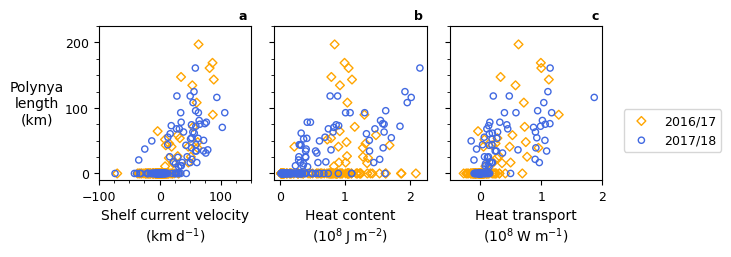

In [36]:
fig, axs = plt.subplots(1,3,figsize=(6.5,2))

# ax.scatter(cum_pack_drifts, all_extents[all_extents>0][::24]/50)

# ax.scatter((daily_mean_IHT[all_extents[::24]>0]/convert).to('cm'), 
#            all_extents[all_extents>0][::24], s=10, c='k', alpha=1)



m1_kwargs = {'edgecolor' : 'orange', 'marker' : 'D', 'facecolor':'None',  's':20, 'alpha':1,}

m2_kwargs = {'edgecolor' : 'royalblue', 'marker' : 'o',  'facecolor':'None', 's':20, 'alpha':1,}


mo_kwargs = {'edgecolor' : 'k', 'marker' : 'o', 'facecolor':'r',  's':30, 'alpha':1,}
lo_kwargs = {'c':'r', 'lw':1, 'alpha':1,}
mc_kwargs = {'edgecolor' : 'k', 'marker' : 'o', 'facecolor':'dodgerblue',  's':30, 'alpha':1,}
lc_kwargs = {'c':'dodgerblue', 'lw':1, 'alpha':1,}

Y1 = (all_years[::24]==2017)
Y2 = (all_years[::24]==2018)

#-------------------------
ax = axs[0]
ax.set_xlabel("Shelf current velocity\n($\mathrm{km\;{d}^{-1}}$)")
ax.set_ylabel('Polynya\nlength\n(km)', rotation=0, labelpad=20, va='center')
ax.xaxis.set_major_locator(ticker.MultipleLocator(100))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(25))
ax.set_xlim(-100,150)

for cond, kw, lab in zip([Y1, Y2], [m1_kwargs, m2_kwargs], ['2016/17', '2017/18']):

    ax.scatter(daily_mean_current[cond], 
               all_length_145s[::24][cond],label=lab, **kw)



# for cond, lk, mk, Y in zip([all_extents[::24]==0, all_extents[::24]>0], 
#                         [lc_kwargs, lo_kwargs], [mc_kwargs, mo_kwargs], [250,260]):
    
#     ax.plot([np.nanpercentile(daily_mean_current.magnitude[cond], 25), 
#                 np.nanpercentile(daily_mean_current.magnitude[cond], 75)], [Y,Y], clip_on=False, **lk)
    
#     ax.scatter(np.nanpercentile(daily_mean_current.magnitude[cond], 50), Y, clip_on=False, **mk)



# ax.plot(daily_mean_current, all_length_145s[::24],  c='k', alpha=1)
# ax.plot([0,150],[0,150])


#-------------------------

ax = axs[1]
ax.set_xlabel('Heat content\n($\mathrm{10^{8}\;J\;{m}^{-2}}$)')

for cond, kw, lab in zip([Y1, Y2], [m1_kwargs, m2_kwargs], ['2016/17', '2017/18']):

    ax.scatter(daily_mean_IHC.magnitude[cond]/1e8, 
               all_length_145s[::24][cond],**kw)
  


# for cond, lk, mk, Y in zip([all_extents[::24]==0, all_extents[::24]>0], 
#                         [lc_kwargs, lo_kwargs], [mc_kwargs, mo_kwargs], [250,260]):
    
#     ax.plot([np.nanpercentile(daily_mean_IHC.magnitude[cond]/1e8, 25), 
#                 np.nanpercentile(daily_mean_IHC.magnitude[cond]/1e8, 75)], [Y,Y], clip_on=False, **lk)
    
#     ax.scatter(np.nanpercentile(daily_mean_IHC.magnitude[cond]/1e8, 50), Y, clip_on=False, **mk)



#-------------------------
ax = axs[2]
ax.set_xlabel('Heat transport\n($\mathrm{10^{8}\;W\;{m}^{-1}}$)')
ax.set_xlim(-0.5,2)
for cond, kw, lab in zip([Y1, Y2], [m1_kwargs, m2_kwargs], ['2016/17', '2017/18']):

    ax.scatter(daily_mean_IHT.to('W/m').magnitude[cond]/1e8, 
               all_length_145s[::24][cond],label=lab, **kw)


# for cond, lk, mk, Y in zip([all_extents[::24]==0, all_extents[::24]>0], 
#                         [lc_kwargs, lo_kwargs], [mc_kwargs, mo_kwargs], [250,260]):
    
#     ax.plot([np.nanpercentile(daily_mean_IHT.to('W/m').magnitude[cond]/1e8, 25), 
#                 np.nanpercentile(daily_mean_IHT.to('W/m').magnitude[cond]/1e8, 75)], [Y,Y], clip_on=False, **lk)
    
#     ax.scatter(np.nanpercentile(daily_mean_IHT.to('W/m').magnitude[cond]/1e8, 50), Y, clip_on=False, **mk)

axs[2].legend(bbox_to_anchor=(1.1,0.5))
    
# ax.set_ylabel('Polynya length')

# ax.scatter((daily_mean_IHT[all_extents[::24]>0]/convert).to('cm'), 
#            all_extents[all_extents>0][::24]/cum_pack_drifts, s=10, c='k', alpha=1)

# ax.set_ylim(-1,10)

plt.subplots_adjust(wspace=0.15)


for ax in axs:
    ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(25))
    ax.set_ylim(-10,225)
for ax in axs[1:]:
    ax.set_yticklabels([])

for aa, ax in enumerate(axs):
    ax.text(0.975,1.025, f'{chr(aa+97)}',va='bottom', ha='right', weight='bold', transform=ax.transAxes)

# fig.savefig('../figures/results/Fig10b.png', dpi=400, bbox_inches='tight', pad_inches=0)

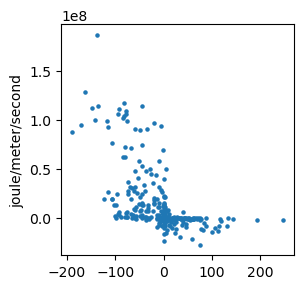

In [124]:
fig, ax = plt.subplots(figsize=(3,3))

ax.scatter(np.sign(daily_mean_u10)*daily_mean_u10**2, daily_mean_IHT, s=5)